In [3]:
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.svm import SVR

In [4]:
data_path = r'data/processed'
data_filenames = os.listdir(data_path)
# data_filenames = ["ADX-TY.zip", "NNN-O.zip"]

models = {}
feature_transformers = {}
feature_scalers = {}
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)

    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = QuantileTransformer()
    quantile_transformer.fit(X_train); feature_transformers[pair] = quantile_transformer
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # scale features
    X_scaler = StandardScaler()
    X_scaler.fit(X_train); feature_scalers[pair] = X_scaler
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    split = PredefinedSplit(test_fold=[0 if v else -1 for v in X_train.index < '2012-01-01'])
    models[pair] = {
        'Linear Regression': GridSearchCV(estimator=ElasticNet(max_iter=100000, tol=0.004), param_grid={
            'l1_ratio': [0.4, 0.5, 0.6]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Support Vector Machine': GridSearchCV(estimator=SVR(cache_size=1000), param_grid={
            'C': [10**n for n in range(-3, 4)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Random Forest': GridSearchCV(estimator=RandomForestRegressor(bootstrap=True), param_grid={
            "n_estimators": [n for n in range(50, 150, 25)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Adaptive Boost': GridSearchCV(estimator=AdaBoostRegressor(), param_grid={
            "n_estimators": [n for n in range(50, 250, 50)],
            "loss": ["linear", "exponential"]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Gradient Boost': GridSearchCV(estimator=GradientBoostingRegressor(loss="huber"), param_grid={
            "n_estimators": [n for n in range(50, 250, 50)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Neural Net': GridSearchCV(estimator=MLPRegressor(solver="lbfgs", max_iter=1000000), param_grid={
            "hidden_layer_sizes": [(250, h1, h2)
                                   for h1 in range(100, 200, 50)
                                   for h2 in range(25, h1//2, 25)]
        }, cv=split, scoring="explained_variance", n_jobs=-1)
    }

    print(f"==================================================\n"
          f"Results for pair {pair}:\n"
          f"- Return Difference Stats:\n"
          f"  - mean: {float(np.mean(y_test)):.06f}\n"
          f"  - std: {float(np.std(y_test)):.06f}\n"
          f"  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:\n"
          f"    {[np.round(i, decimals=6) for i in np.quantile(y_test, [0, .25, .50, .75, 1])]}")
    pred_average = None
    for model_type, model in models[pair].items():
        model.fit(X_train, np.array(y_train).ravel())
        pred = model.predict(X_test)
        if any(model_type == t for t in ["Random Forest", "Adaptive Boost", "Gradient Boost", "Neural Net"]):
            if pred_average is None: pred_average = pred / 4
            else: pred_average = pred_average + np.array(pred / 4)
        mse = mean_squared_error(np.array(y_test), np.array(pred).ravel())
        mae = median_absolute_error(np.array(y_test), np.array(pred).ravel())
        print(f"- Model: {model_type}\n"
              f"  - best parameters: {model.best_params_}\n"
              f"  - MSE: {mse:.06f}\n"
              f"  - MAE: {mae:.06f}\n"
              f"--------------------------------------------------")
    mse = mean_squared_error(np.array(y_test), np.array(pred_average).ravel())
    mae = median_absolute_error(np.array(y_test), np.array(pred_average).ravel())
    print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net\n"
          f"  - MSE: {mse:.06f}\n"
          f"  - MAE: {mae:.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")

('BAC', 'WFC')
Results for pair ('BAC', 'WFC'):
- Return Difference Stats:
  - mean: 0.000626
  - std: 0.011499
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.051772, -0.005444, 0.000387, 0.006517, 0.083289]
- Model: Linear Regression
  - best parameters: {'l1_ratio': 0.4}
  - MSE: 0.000134
  - MAE: 0.005997
--------------------------------------------------
- Model: Support Vector Machine
  - best parameters: {'C': 0.001}
  - MSE: 0.000261
  - MAE: 0.011671
--------------------------------------------------
- Model: Random Forest
  - best parameters: {'n_estimators': 125}
  - MSE: 0.000000
  - MAE: 0.000007
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'linear', 'n_estimators': 150}
  - MSE: 0.000012
  - MAE: 0.002650
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 200}
  - MSE: 0.000000
  - MAE: 0.000071
--------------------------------------------------


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_mat_all = None
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)

    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = feature_transformers[pair]
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1

    # scale features
    X_scaler = feature_scalers[pair]
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    print(f"==================================================\n"
          f"Results for pair {pair}:")
    pred_ensemble = None
    for model_type, model in models[pair].items():
        pred = [-1 if i < 0 else 1 for i in np.array(model.predict(X_test)).ravel()]
        if any(model_type == t for t in ["Random Forest", "Adaptive Boost", "Gradient Boost", "Neural Net"]):
            if pred_ensemble is None: pred_ensemble = np.array(pred) / 4
            else: pred_ensemble = pred_ensemble + (np.array(pred) / 4)

        conf_mat = confusion_matrix(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        accuracy = accuracy_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        precision = precision_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        recall = recall_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        f1 = f1_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])

        print(f"- Model: {model_type}\n"
              f"  - Confusion Matrix:\n{conf_mat}\n"
              f"  - Accuracy: {accuracy:.06f}\n"
              f"  - Recall: {recall:.06f}\n"
              f"  - Precision: {precision:.06f}\n"
              f"  - F1-Score: {f1:.06f}\n"
              f"--------------------------------------------------")

    conf_mat = confusion_matrix(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    accuracy = accuracy_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    precision = precision_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    recall = recall_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    f1 = f1_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])

    if conf_mat_all is None: conf_mat_all = np.array(conf_mat)
    else: conf_mat_all = conf_mat_all + np.array(conf_mat)

    print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net\n"
          f"  - Confusion Matrix:\n{conf_mat}\n"
          f"  - Accuracy: {accuracy:.06f}\n"
          f"  - Recall: {recall:.06f}\n"
          f"  - Precision: {precision:.06f}\n"
          f"  - F1-Score: {f1:.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")


print(f"- Confusion Matrix of ensemble prediction across all pairs\n{conf_mat_all}\n"
      f"  - Accuracy: {(conf_mat_all[0][0]+conf_mat_all[1][1]) / np.sum(conf_mat_all):.06f}\n"
      f"--------------------------------------------------")
print(f"==================================================\n")


('BAC', 'WFC')
Results for pair ('BAC', 'WFC'):
- Model: Linear Regression
  - Confusion Matrix:
[[749   0]
 [801   0]]
  - Accuracy: 0.483226
  - Recall: 0.000000
  - Precision: 0.000000
  - F1-Score: 0.000000
--------------------------------------------------
- Model: Support Vector Machine
  - Confusion Matrix:
[[749   0]
 [801   0]]
  - Accuracy: 0.483226
  - Recall: 0.000000
  - Precision: 0.000000
  - F1-Score: 0.000000
--------------------------------------------------
- Model: Random Forest
  - Confusion Matrix:
[[749   0]
 [  4 797]]
  - Accuracy: 0.997419
  - Recall: 0.995006
  - Precision: 1.000000
  - F1-Score: 0.997497
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[749   0]
 [ 75 726]]
  - Accuracy: 0.951613
  - Recall: 0.906367
  - Precision: 1.000000
  - F1-Score: 0.950884
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[745   4]
 [  0 801]]
  - Accuracy: 0.997419
  - Re

/Users/Aaditya/.conda/envs/RNNforPairsTrading/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Aaditya/.conda/envs/RNNforPairsTrading/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Aaditya/.conda/envs/RNNforPairsTrading/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Aaditya/.conda/env

('BAC', 'WFC')
Results for pair ('BAC', 'WFC'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[747   2]
 [  2 799]]
  - Accuracy: 0.997419
  - Recall: 0.997503
  - Precision: 0.997503
  - F1-Score: 0.997503
- Annualized Return:
  - BAC: 0.018066
  - WFC: -0.126876
  - Pairs Trade: 0.650444
--------------------------------------------------

('HP', 'PTEN')
Results for pair ('HP', 'PTEN'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[769   4]
 [  0 777]]
  - Accuracy: 0.997419
  - Recall: 1.000000
  - Precision: 0.994878
  - F1-Score: 0.997433
- Annualized Return:
  - HP: -0.311207
  - PTEN: -0.489969
  - Pairs Trade: 1.754842
--------------------------------------------------

('AEG', 'ING')
Results for pair ('AEG', 'ING'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[777   0]
 [  2 771]]
  - Accuracy: 0.998710
  - Recall: 0.9

<ipython-input-6-23e78df0474f>:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(11, 9))


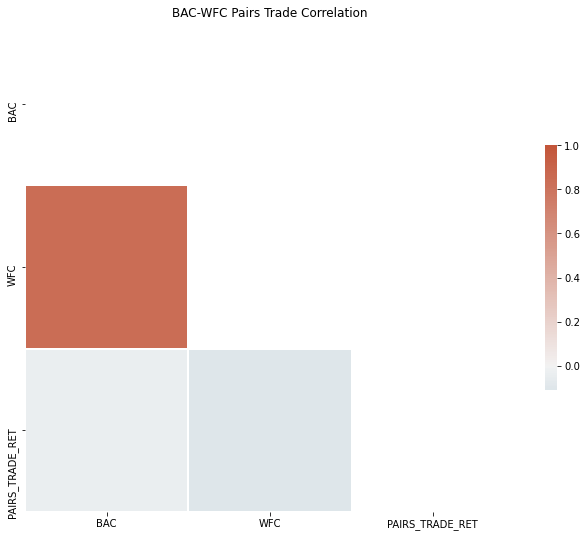

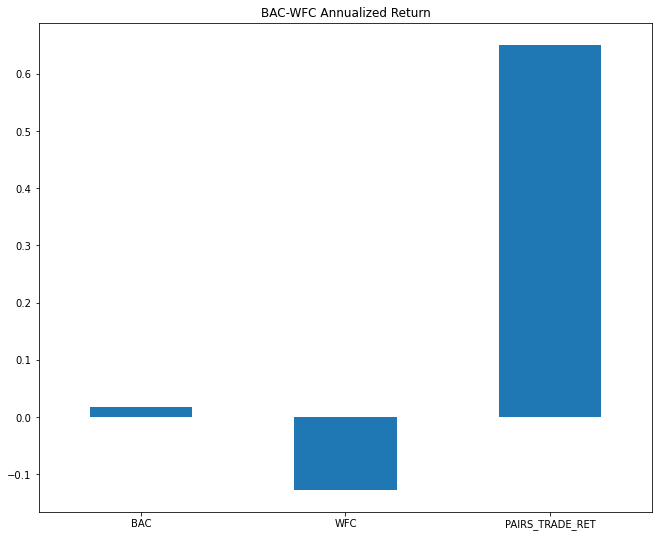

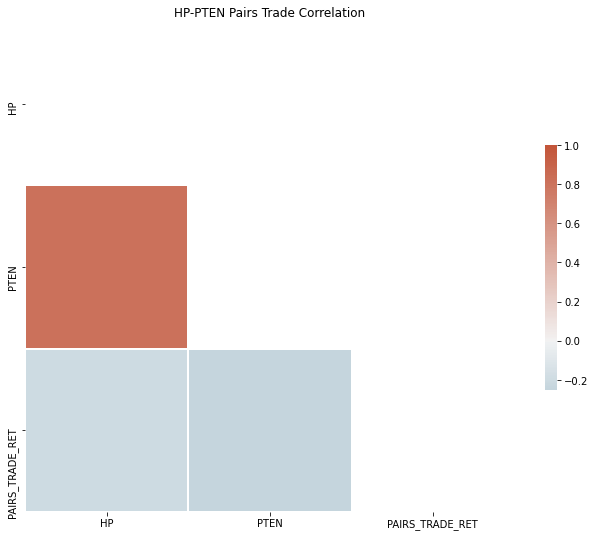

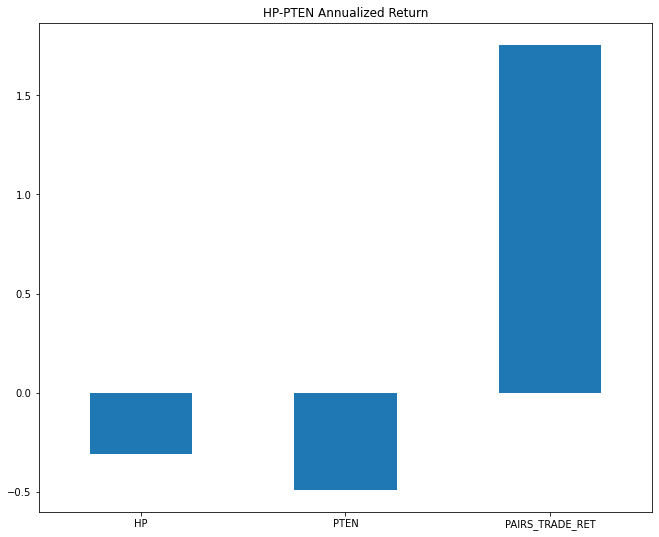

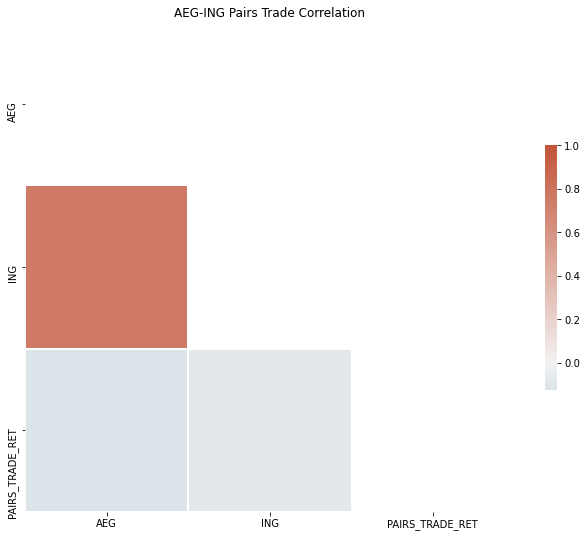

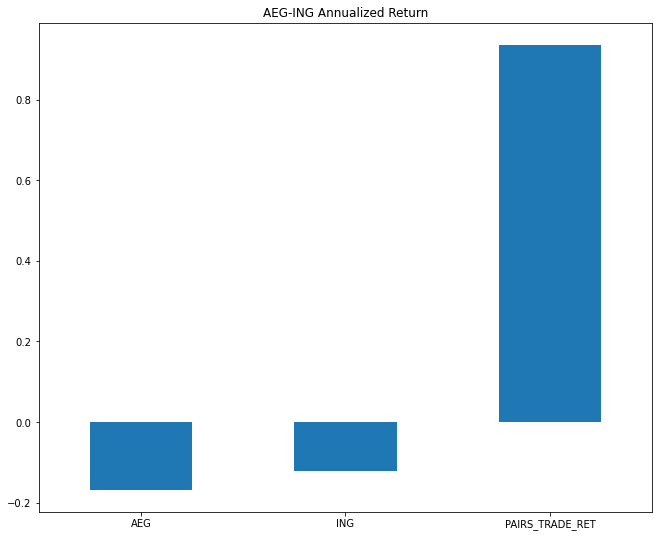

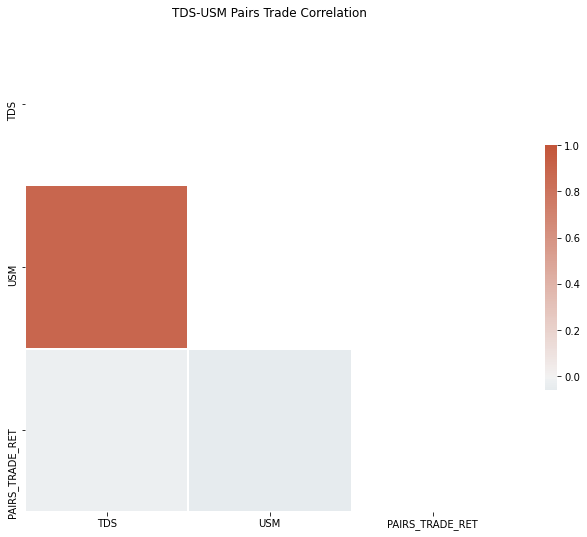

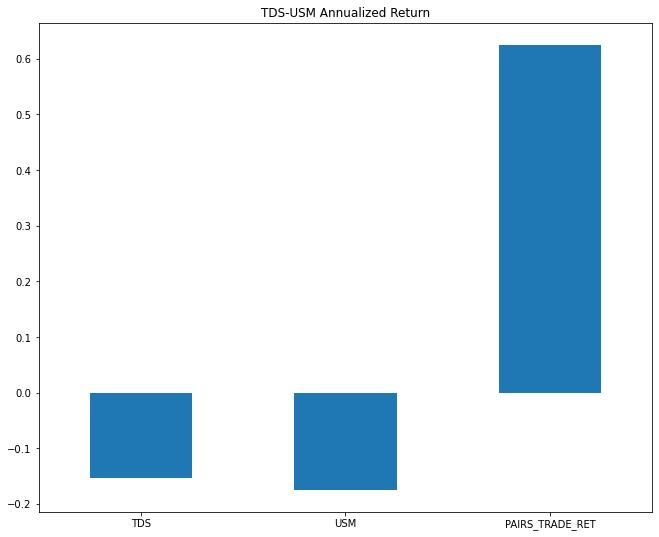

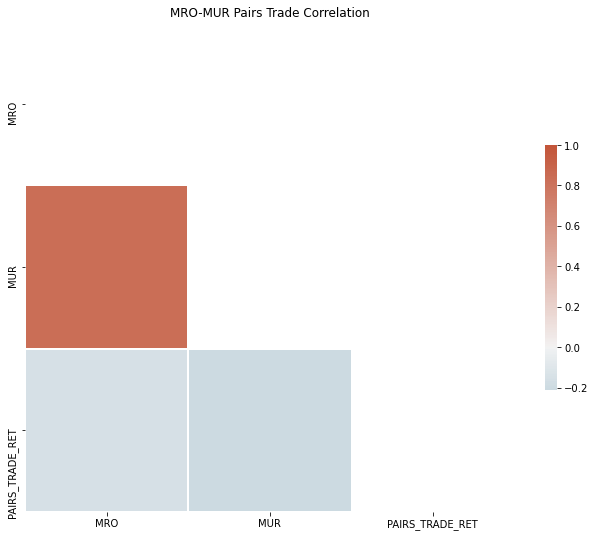

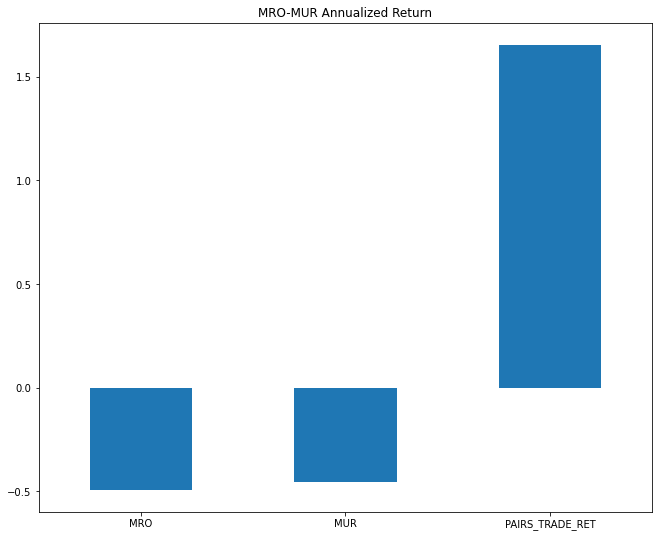

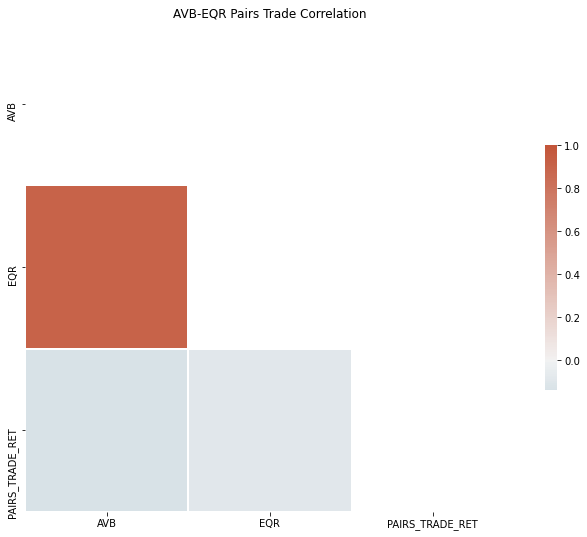

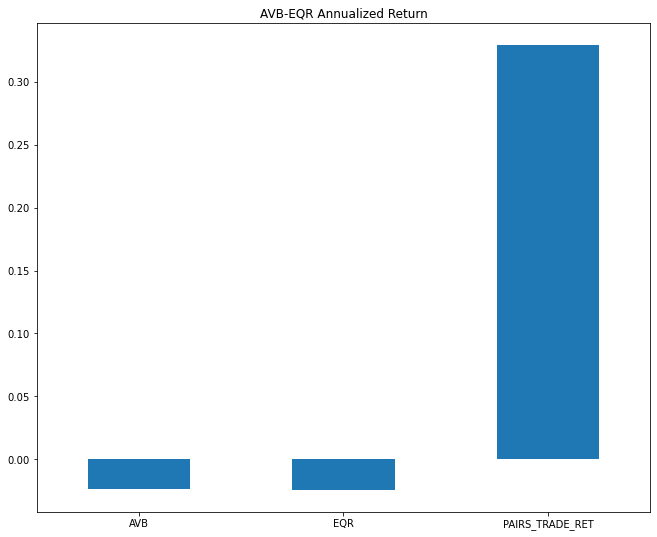

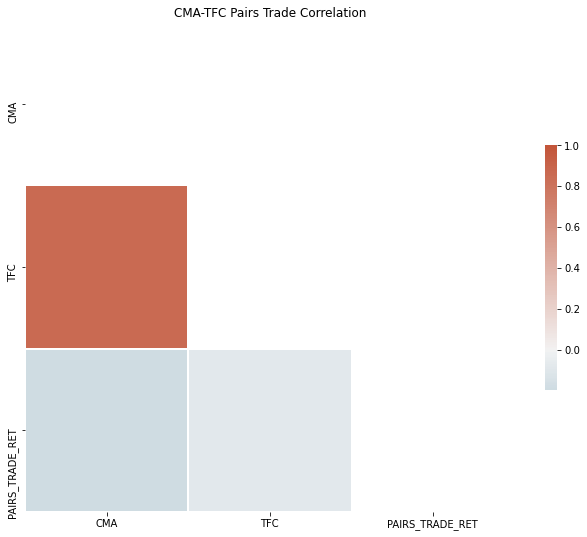

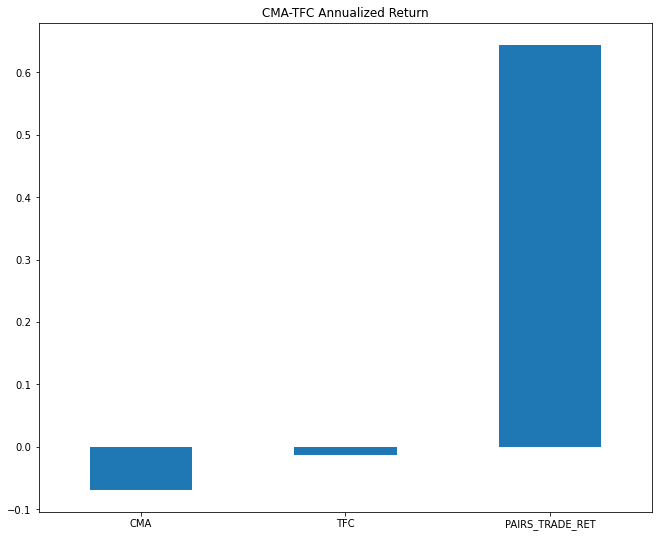

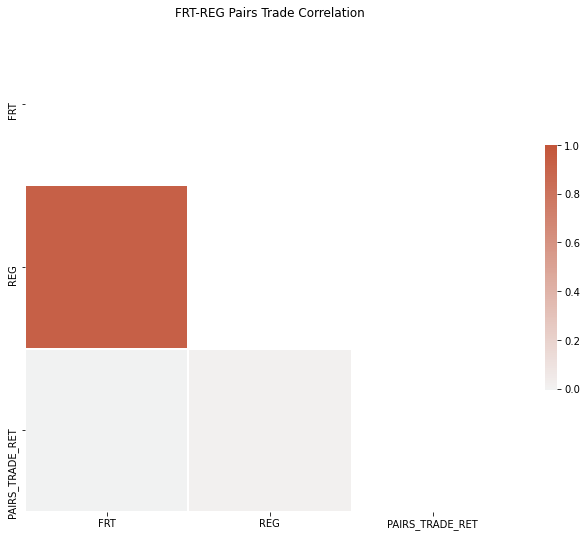

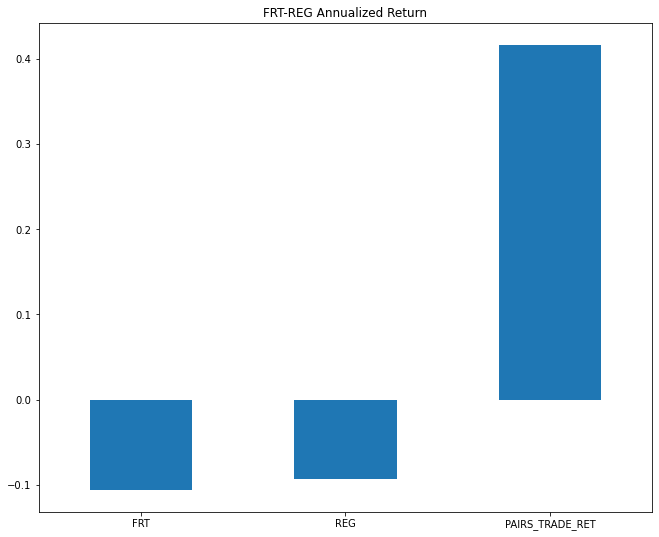

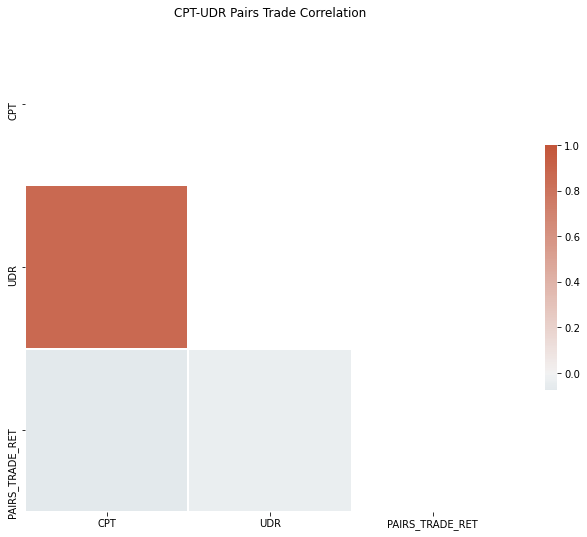

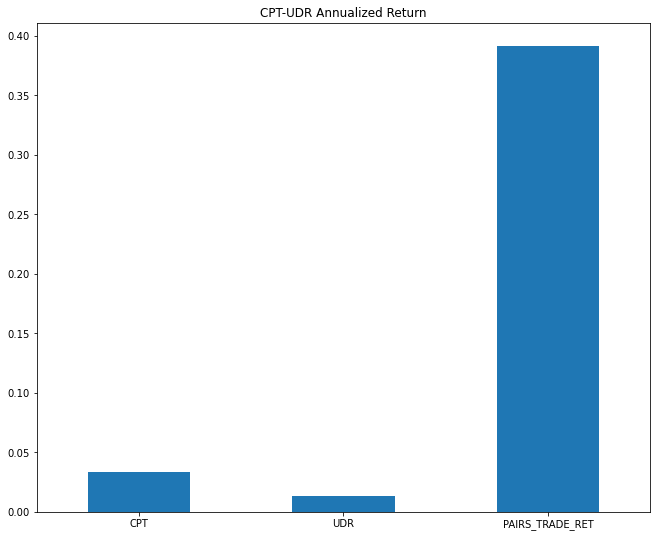

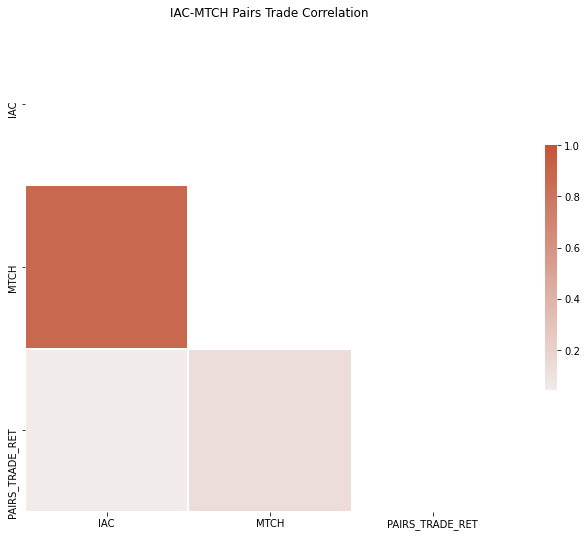

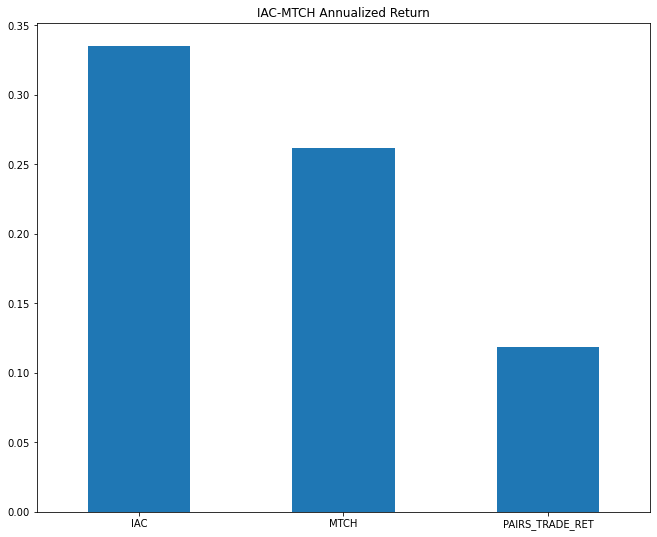

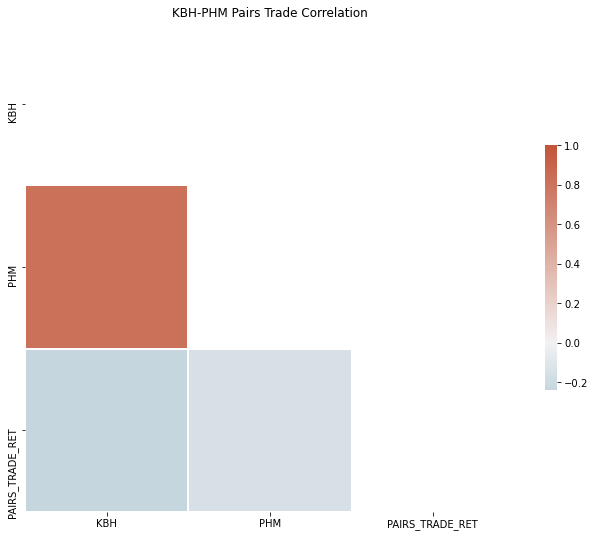

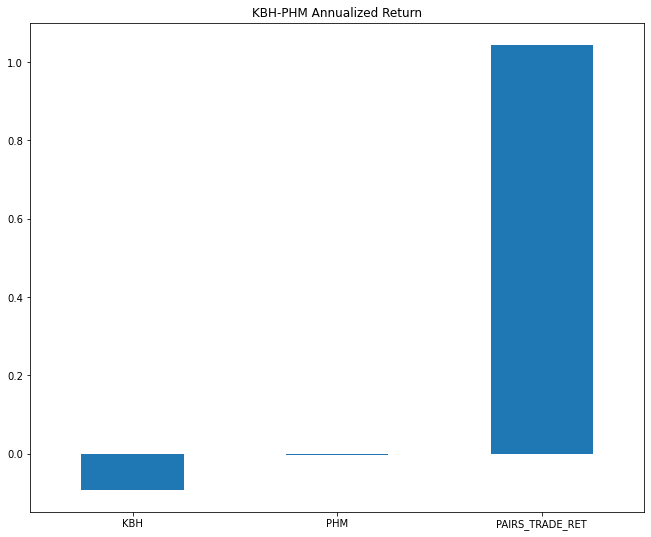

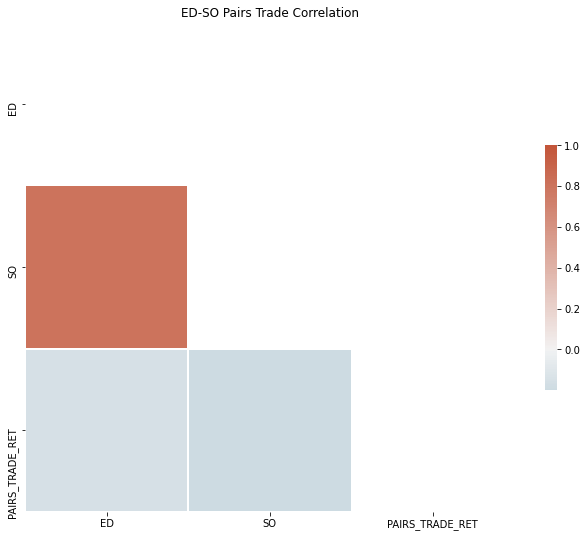

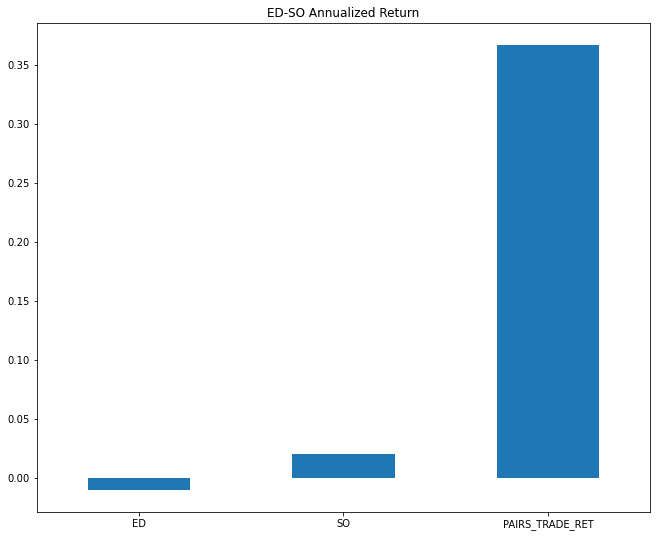

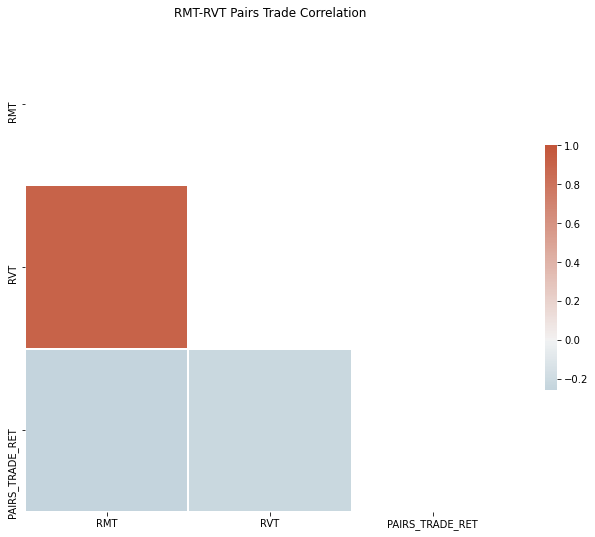

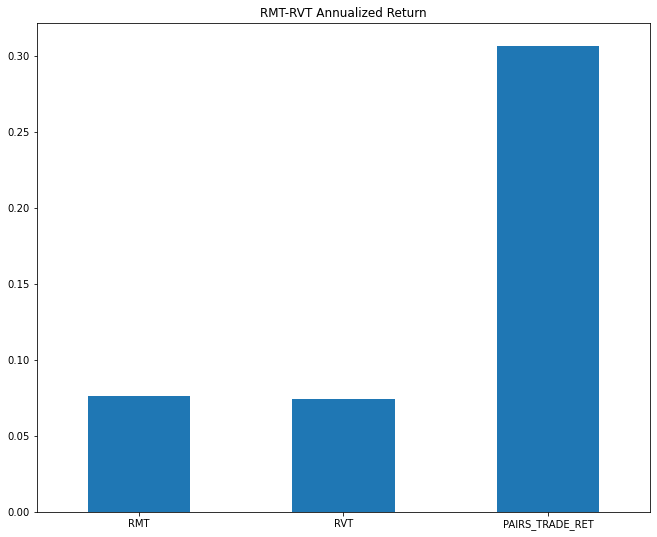

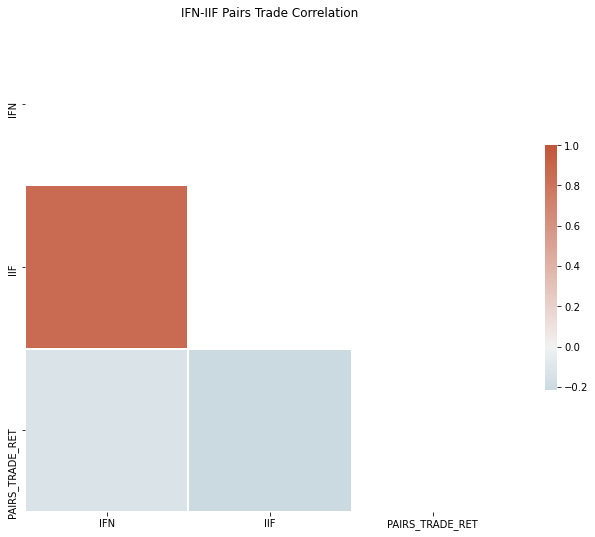

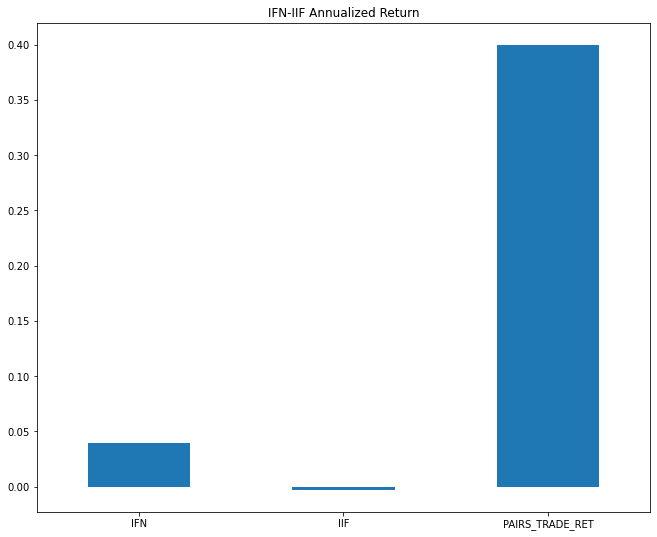

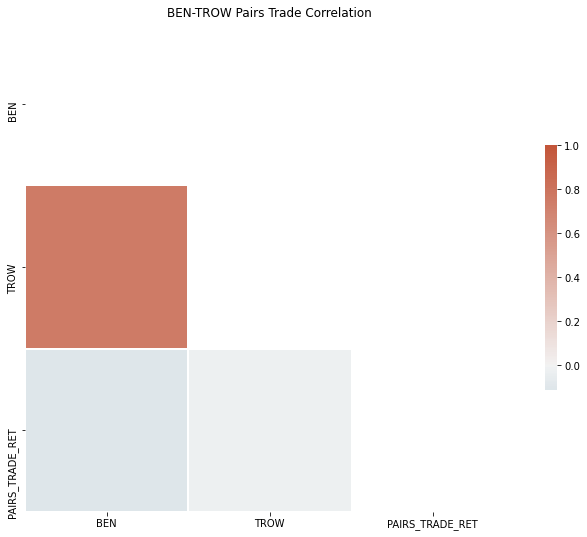

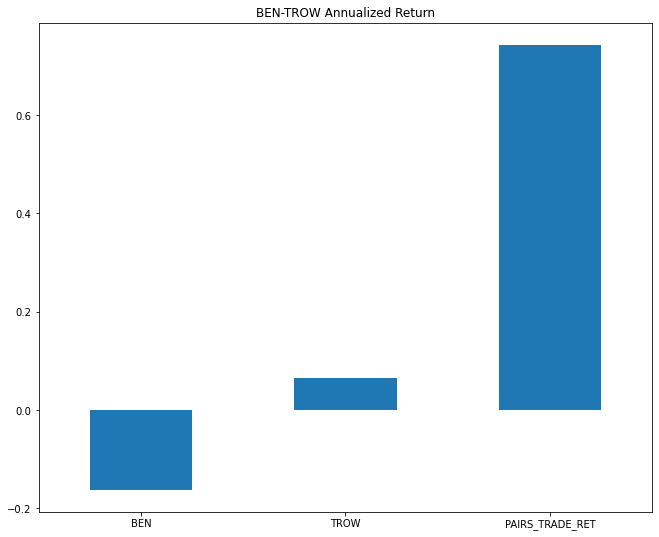

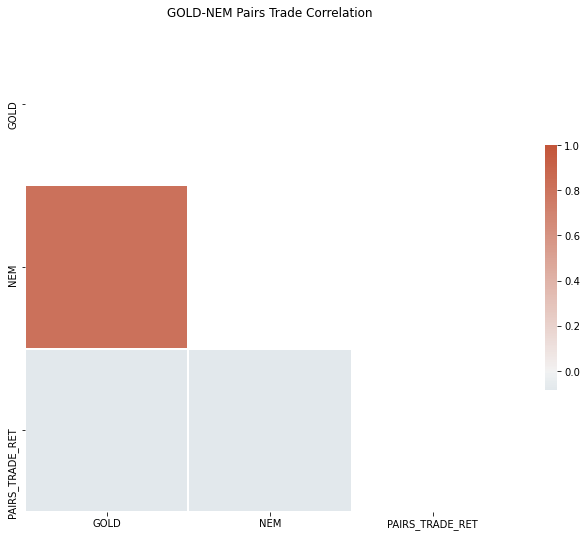

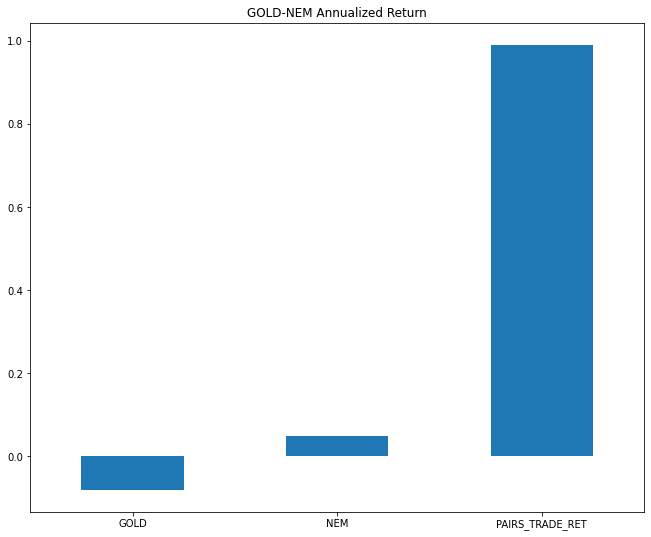

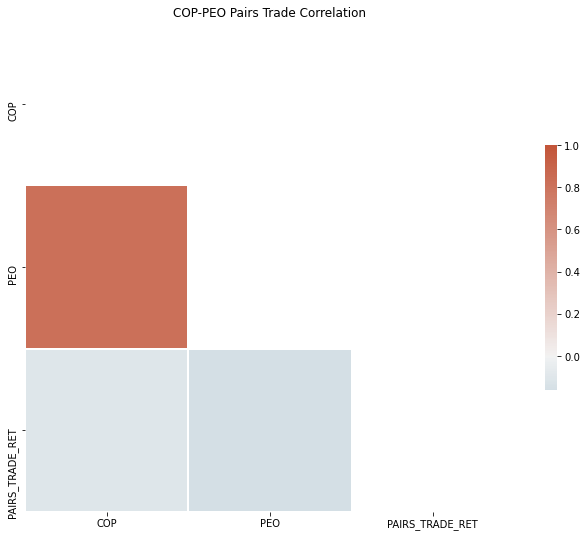

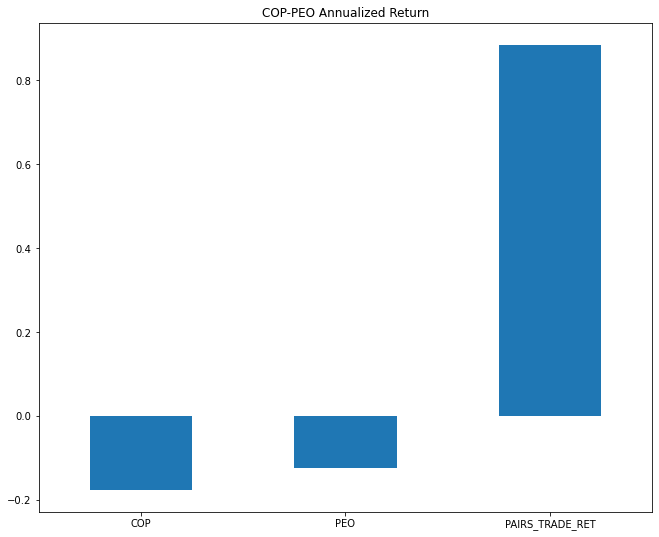

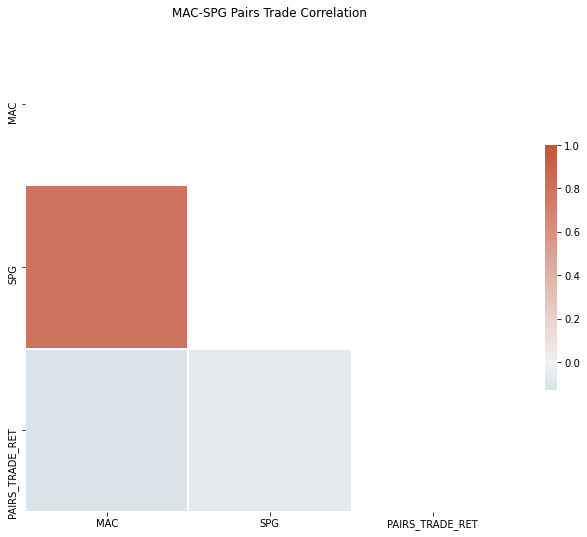

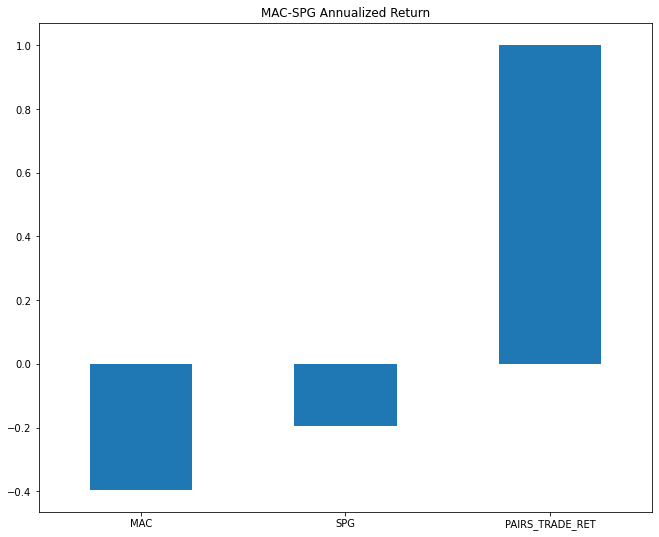

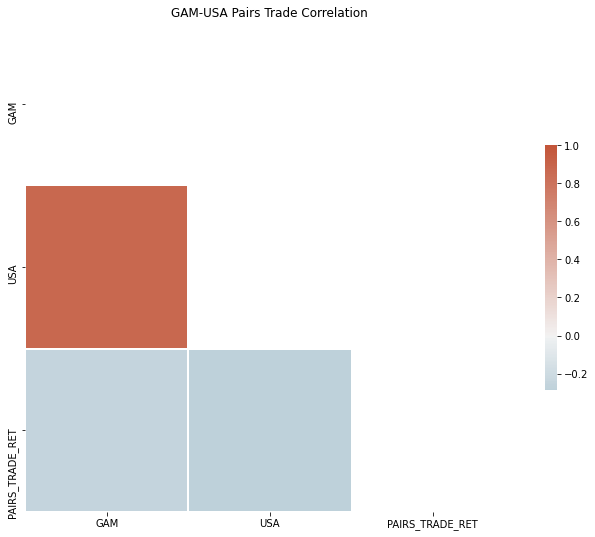

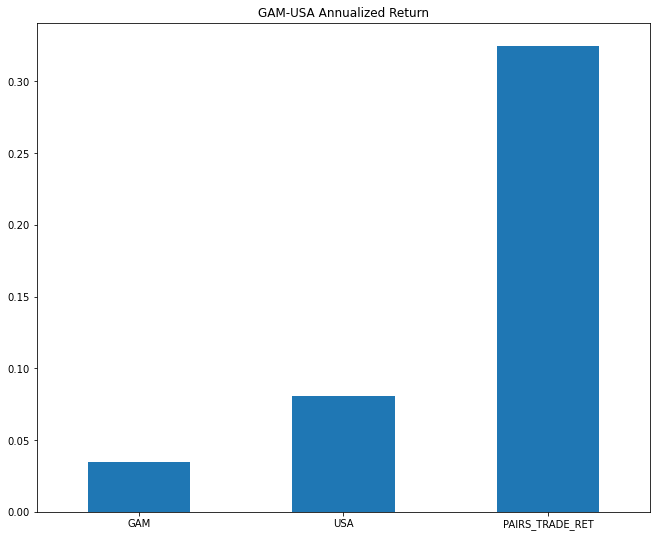

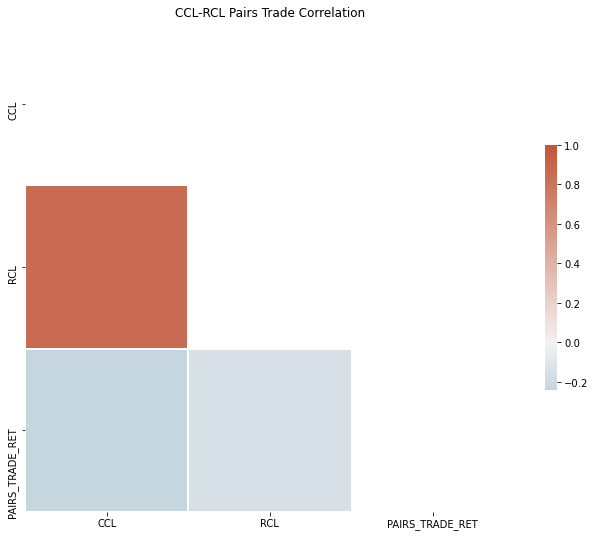

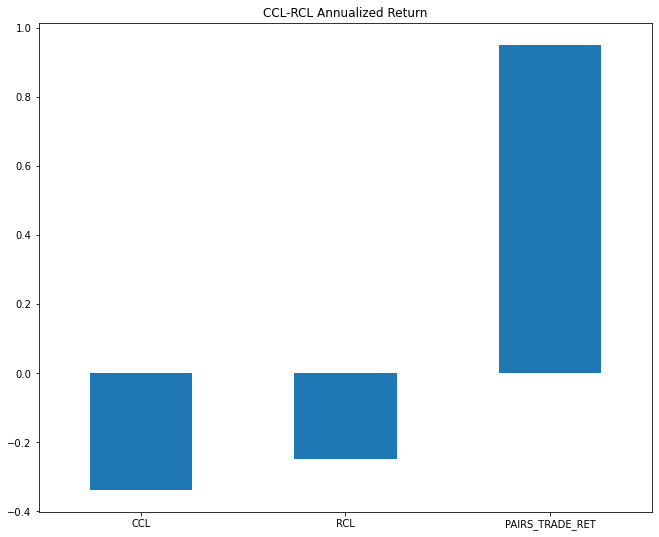

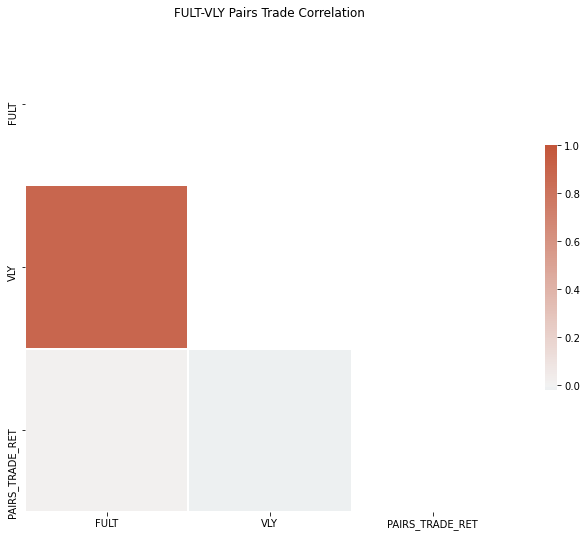

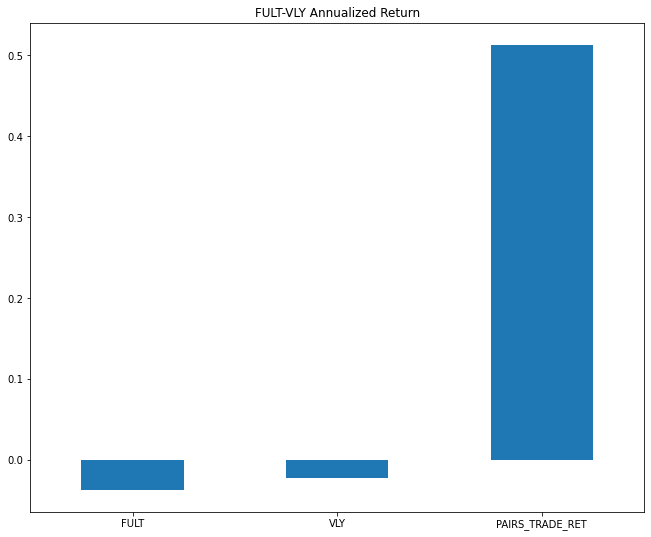

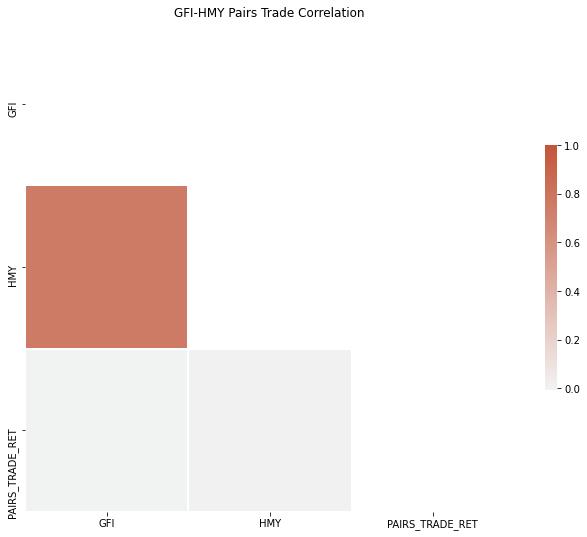

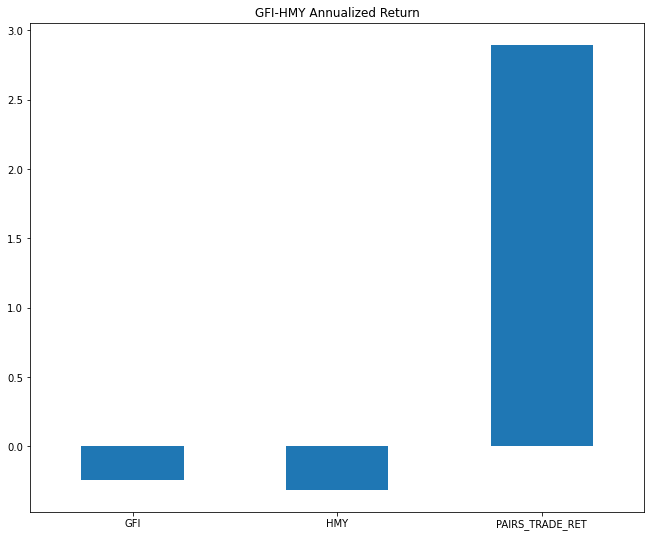

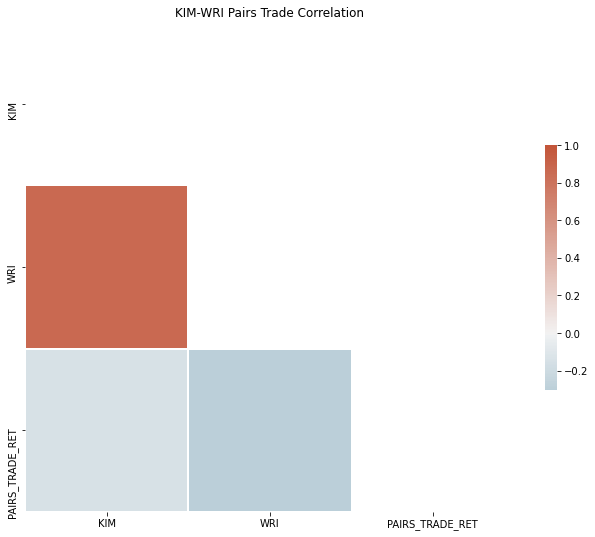

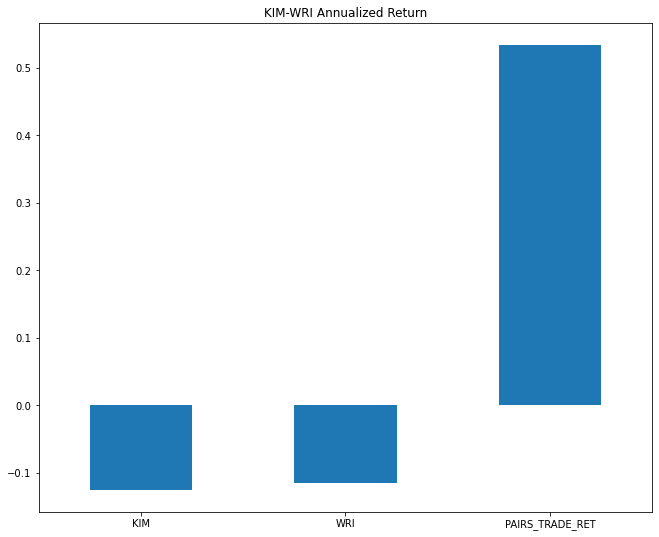

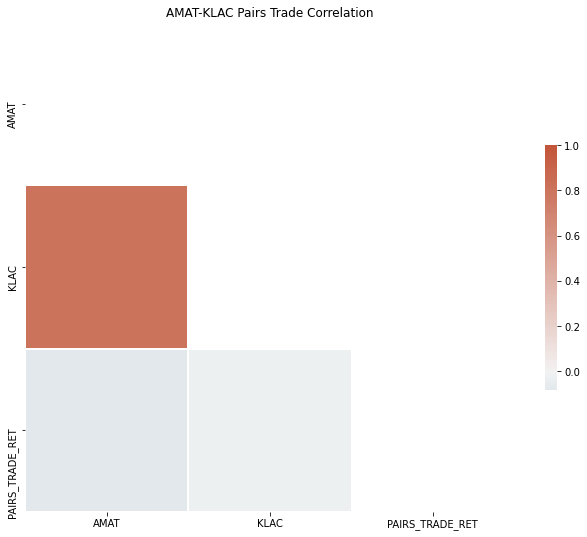

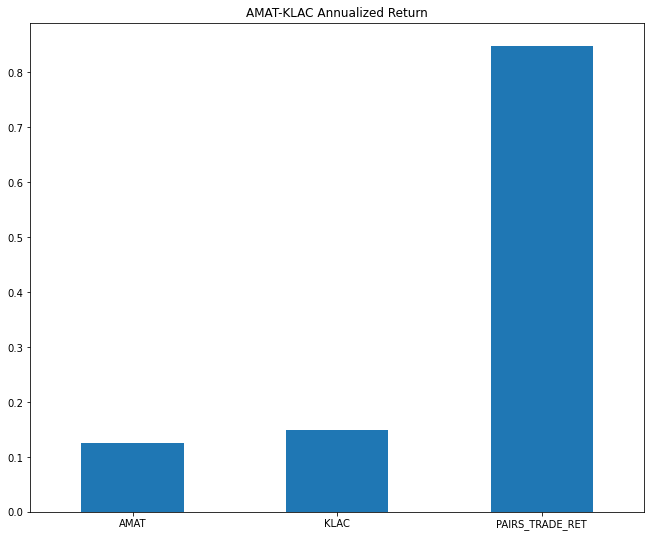

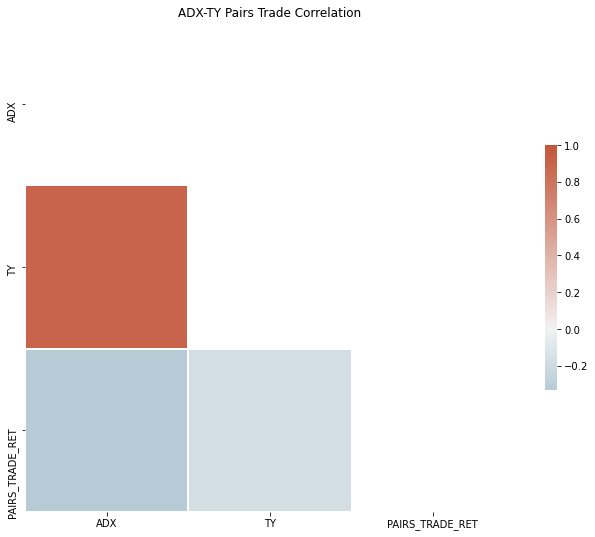

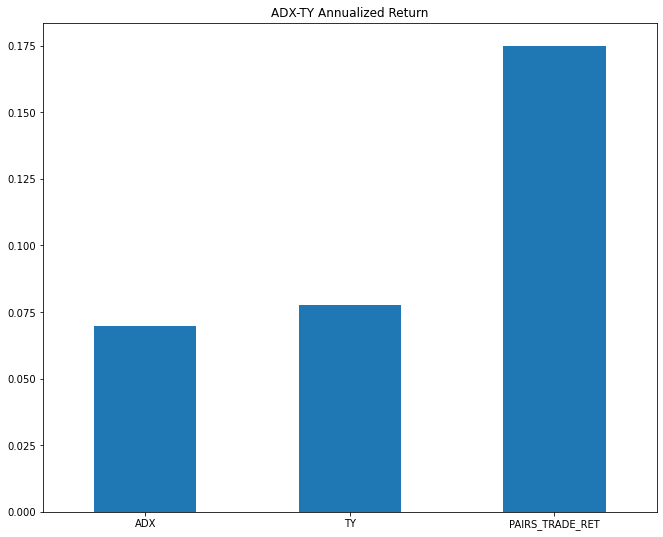

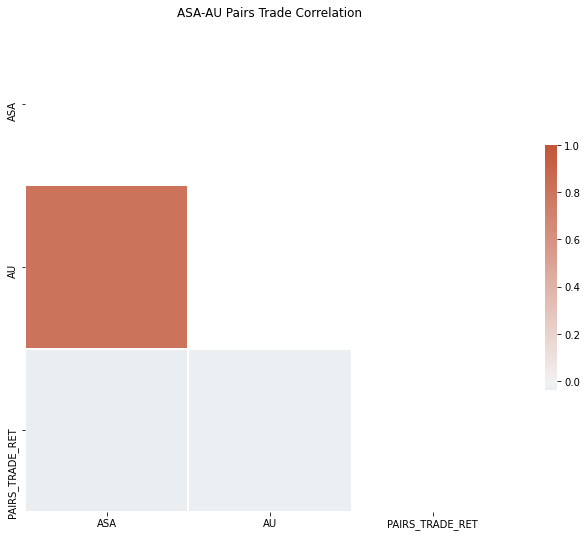

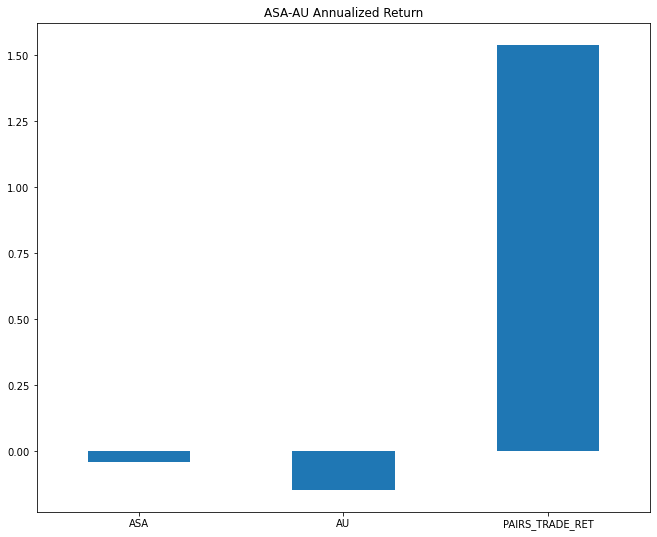

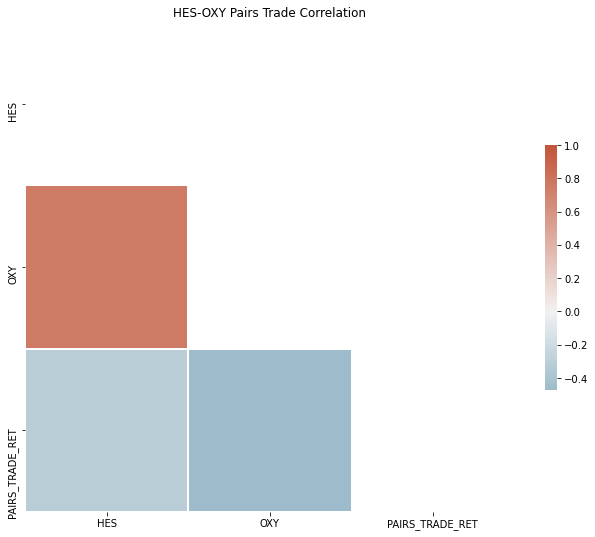

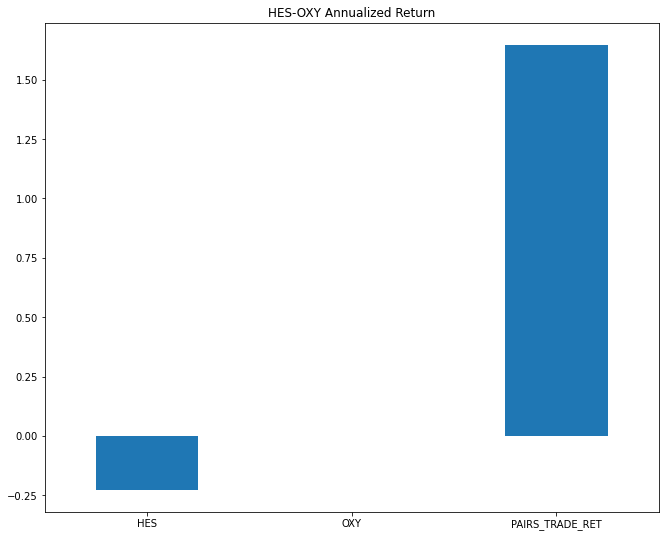

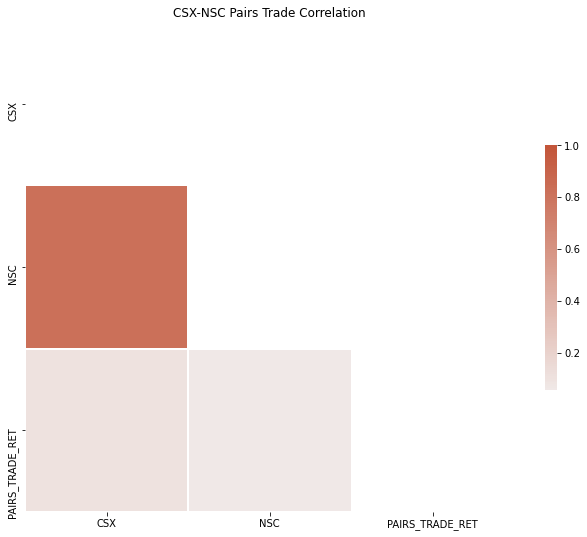

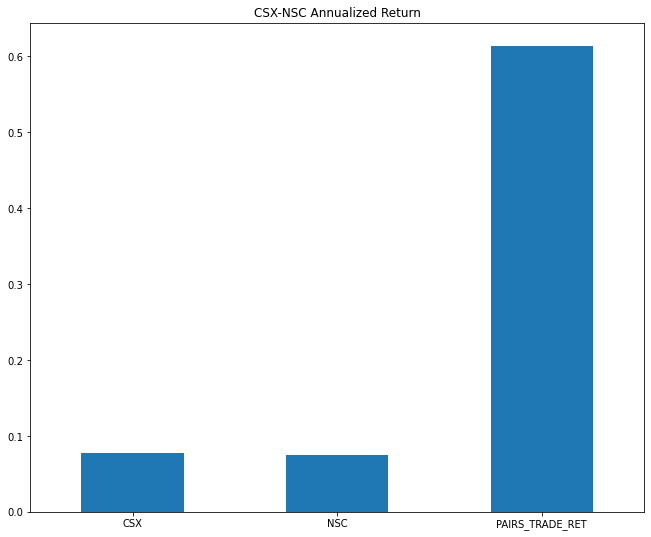

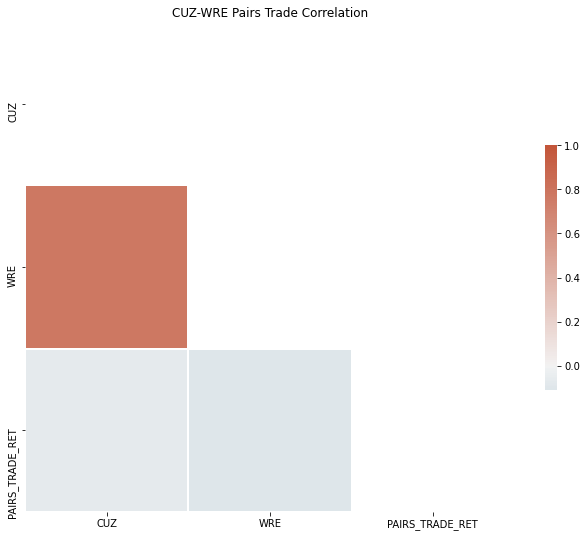

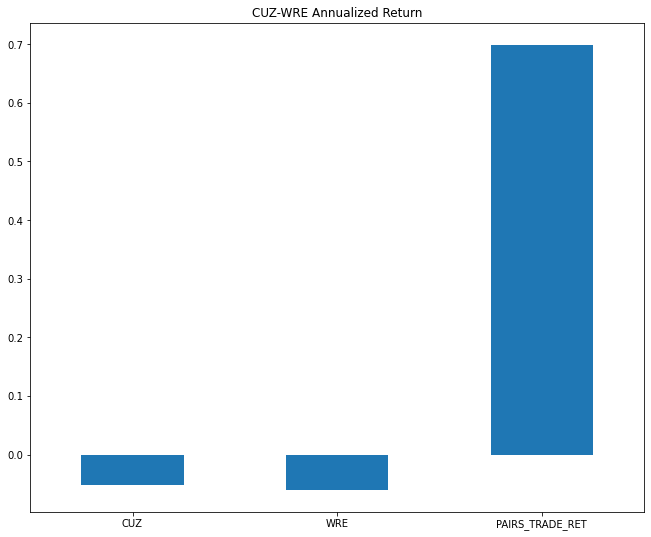

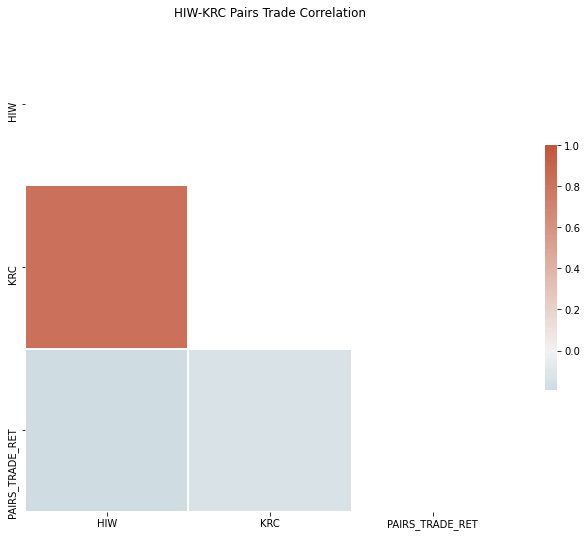

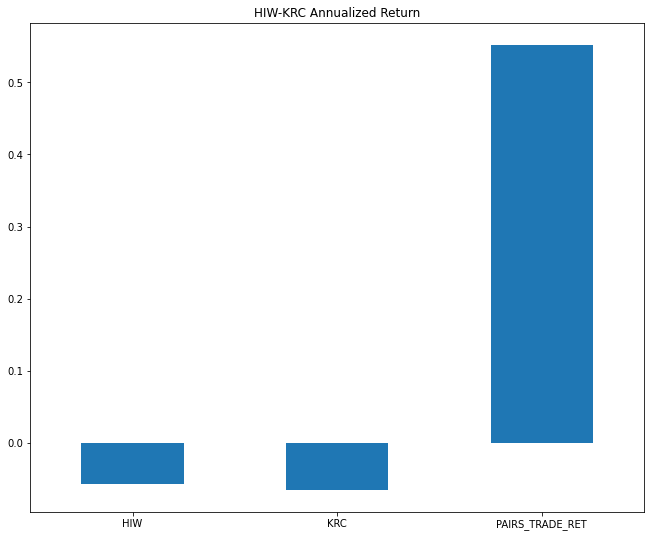

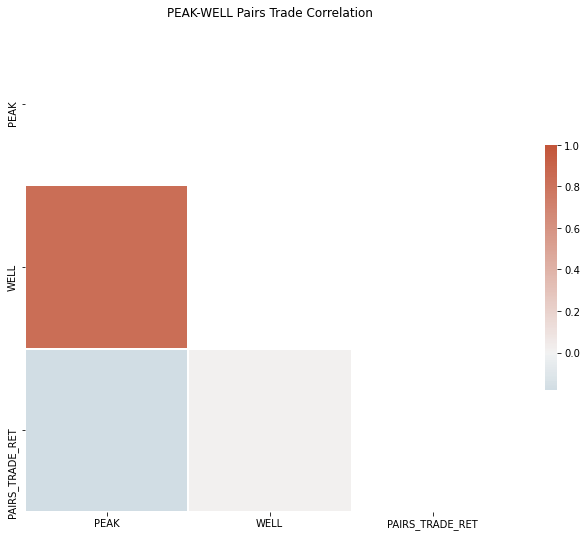

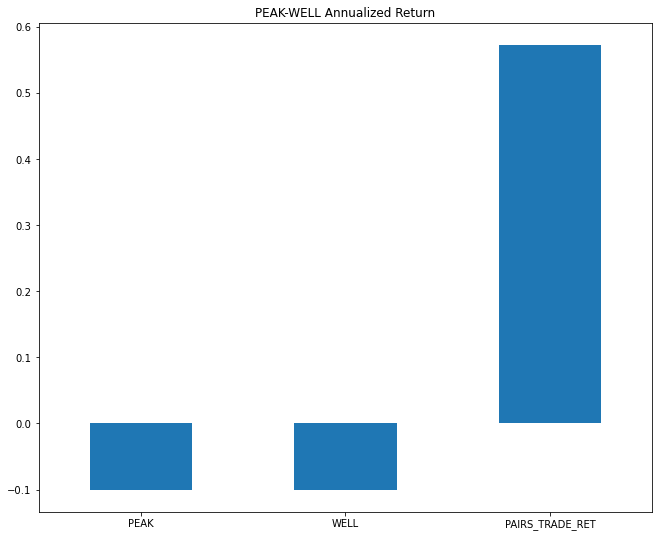

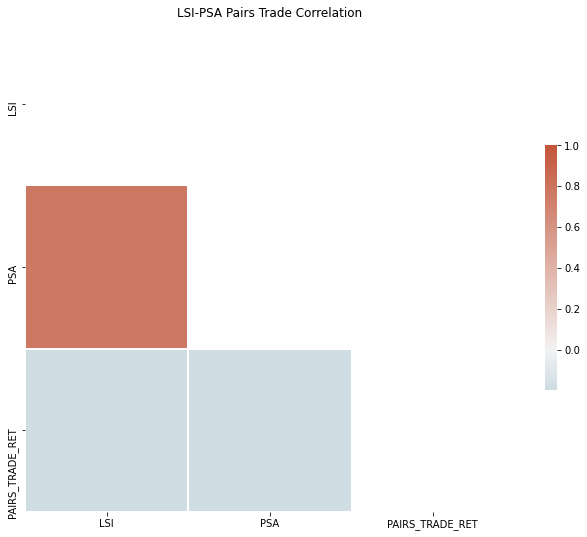

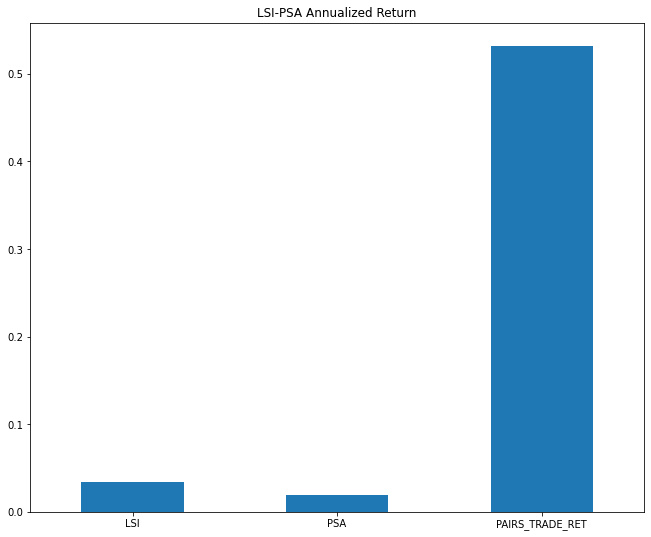

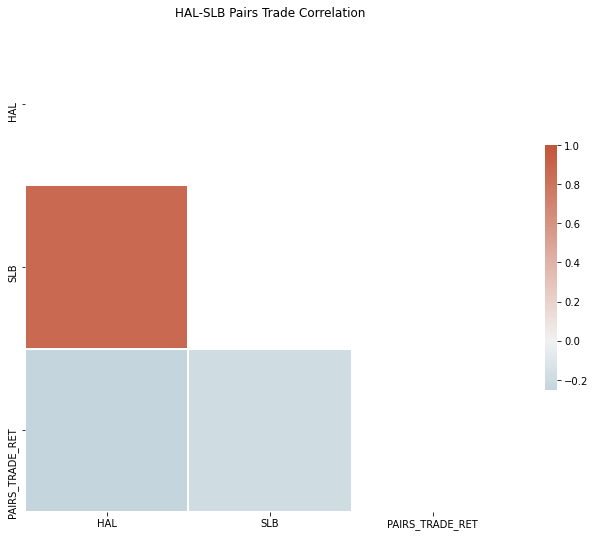

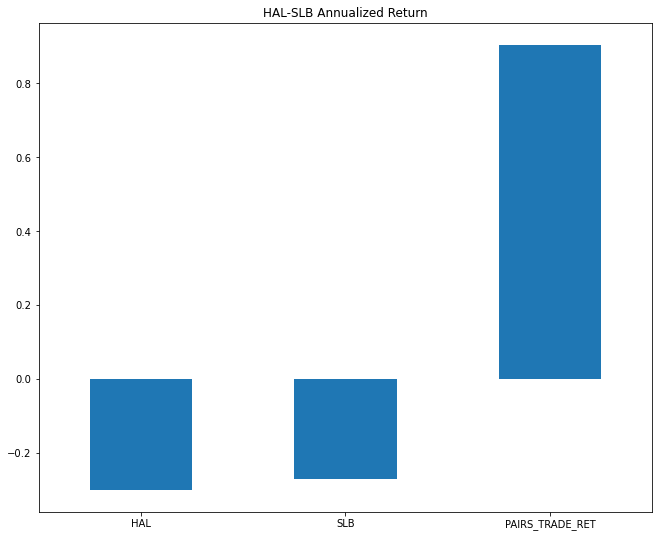

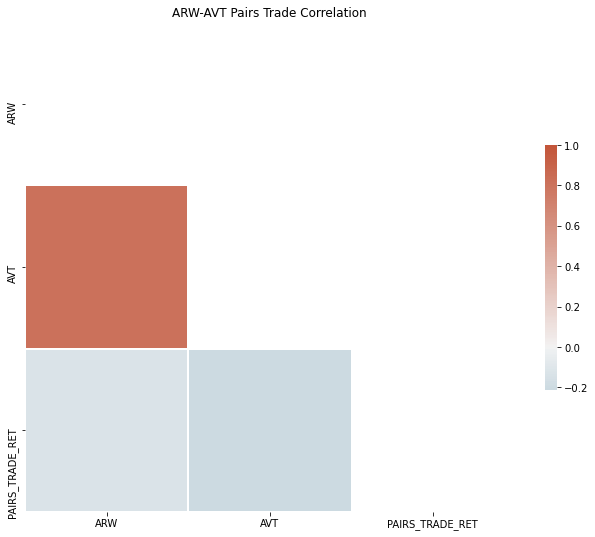

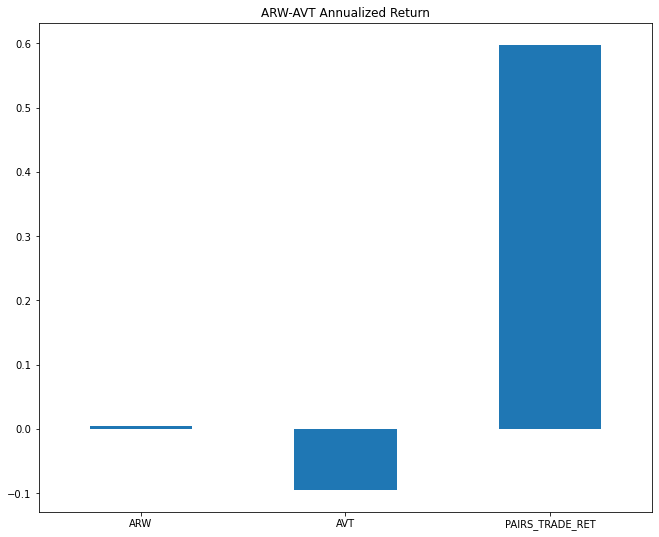

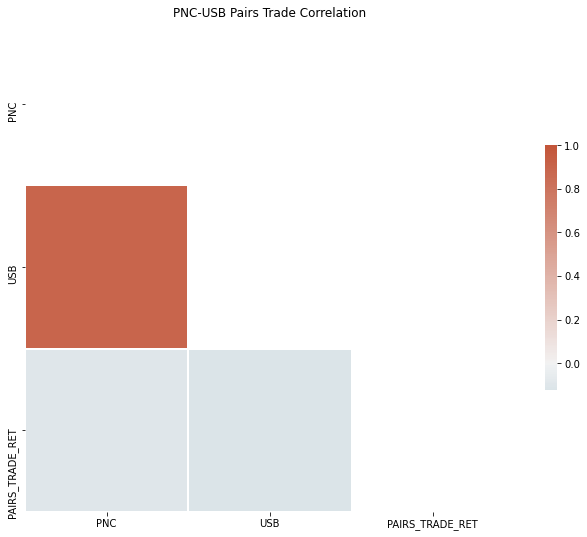

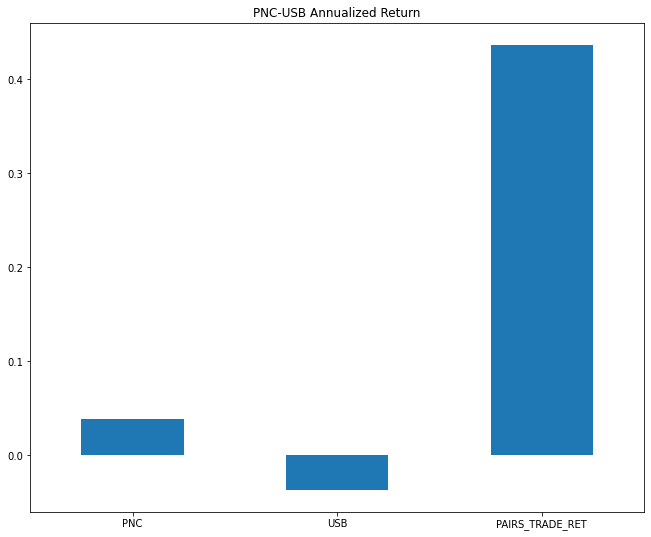

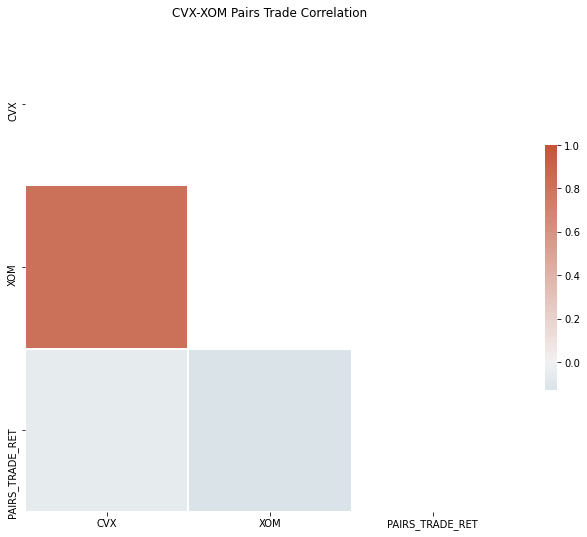

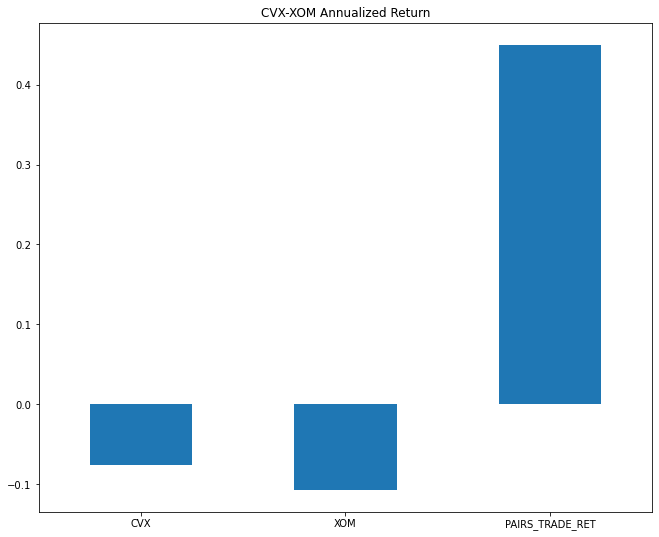

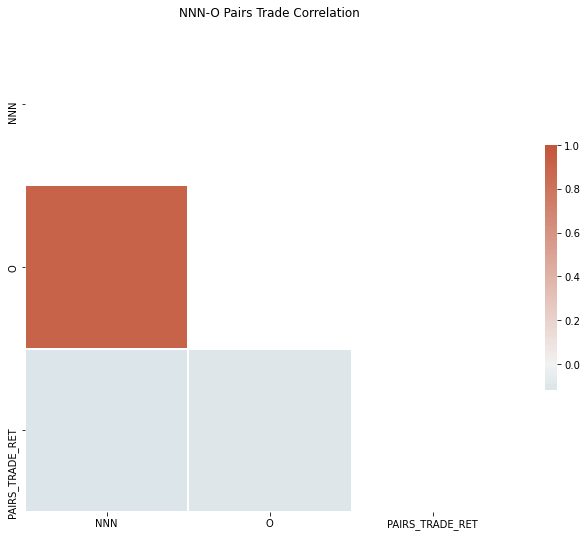

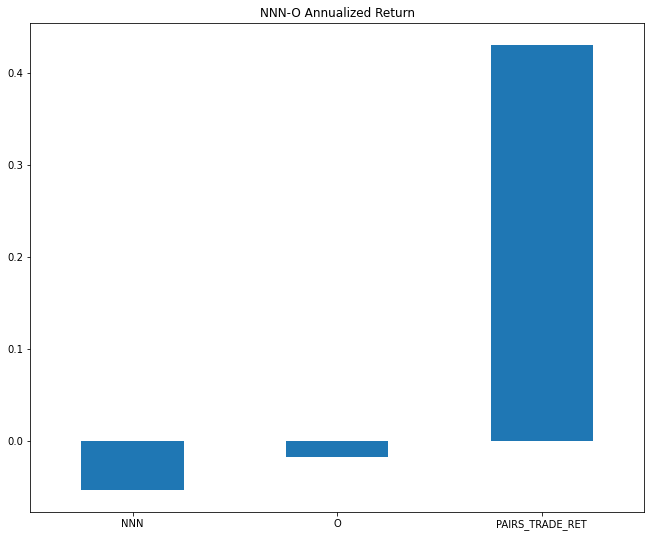

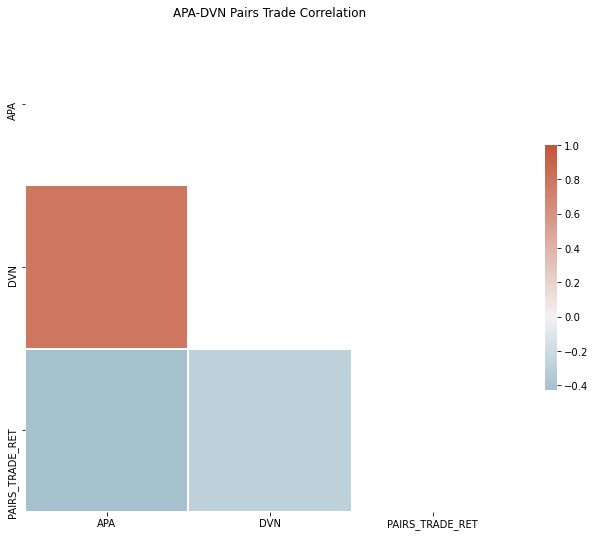

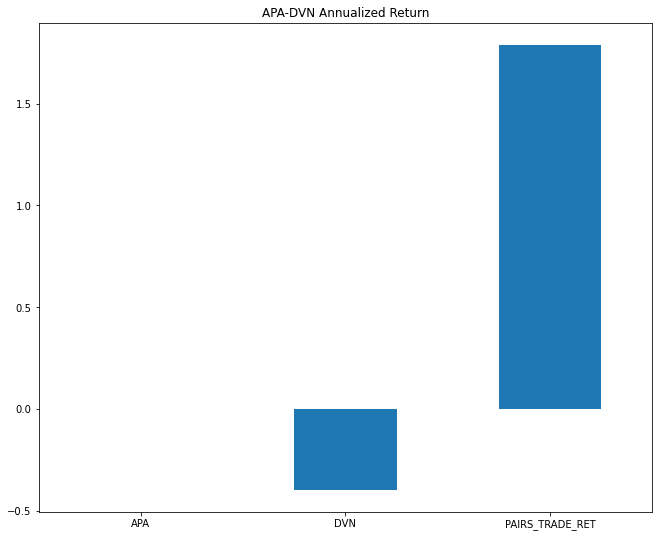

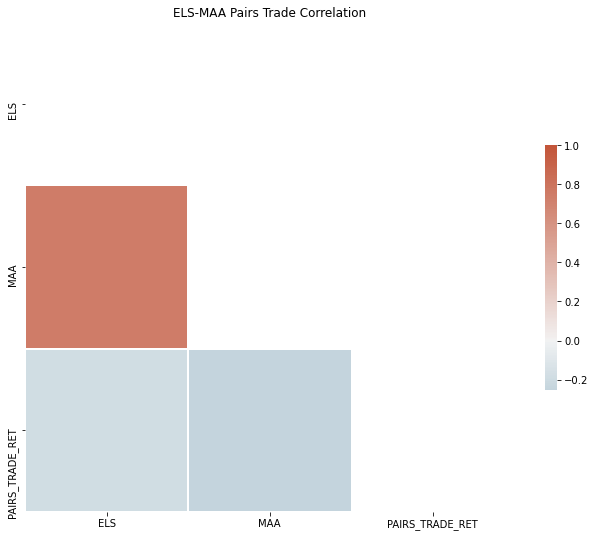

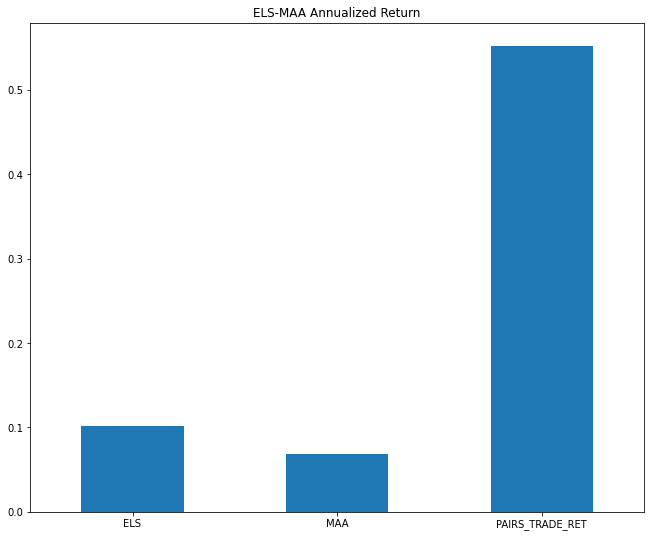

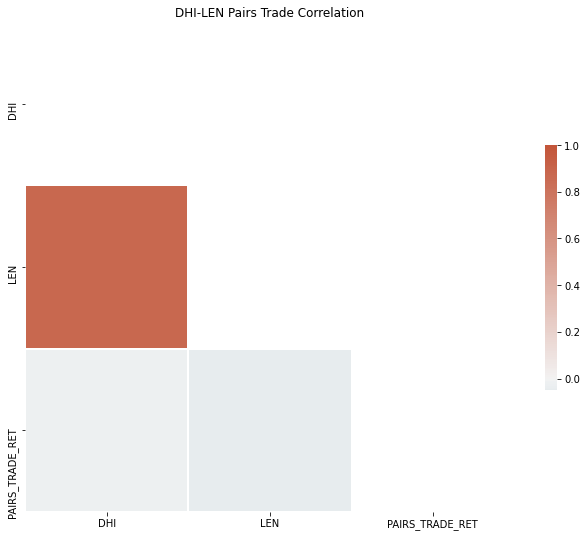

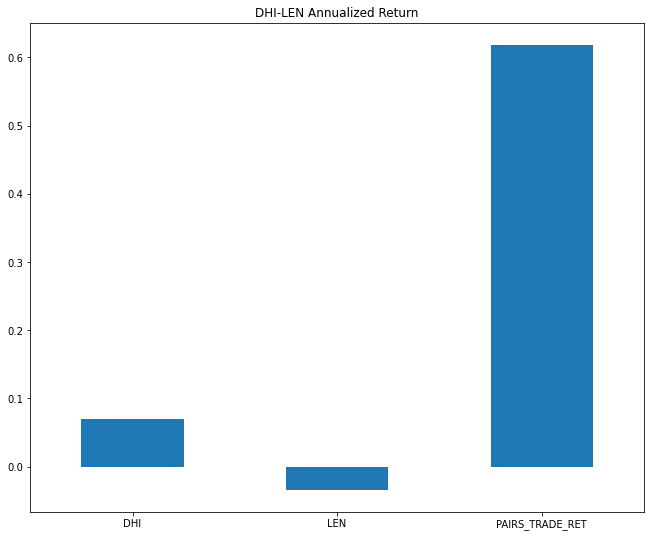

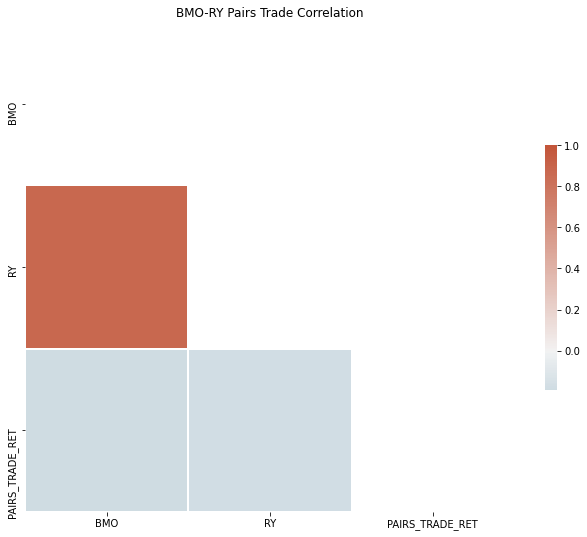

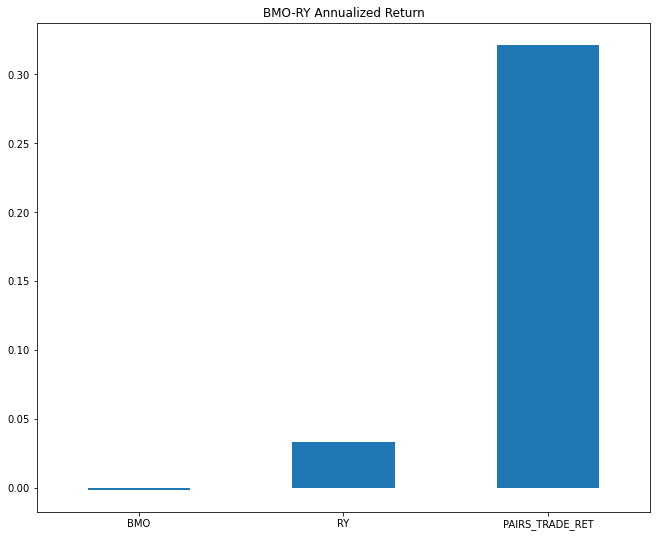

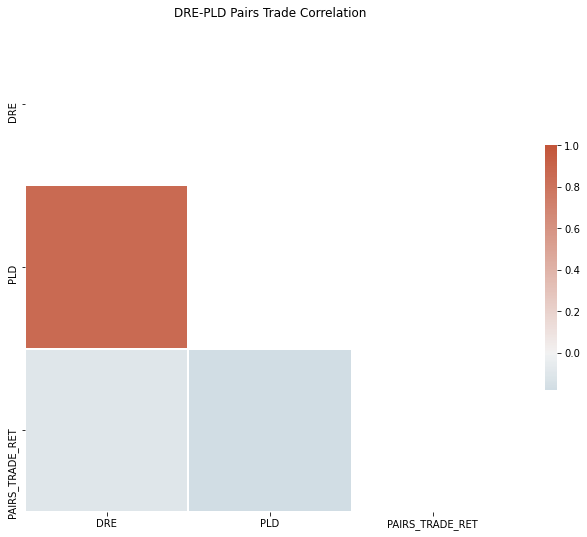

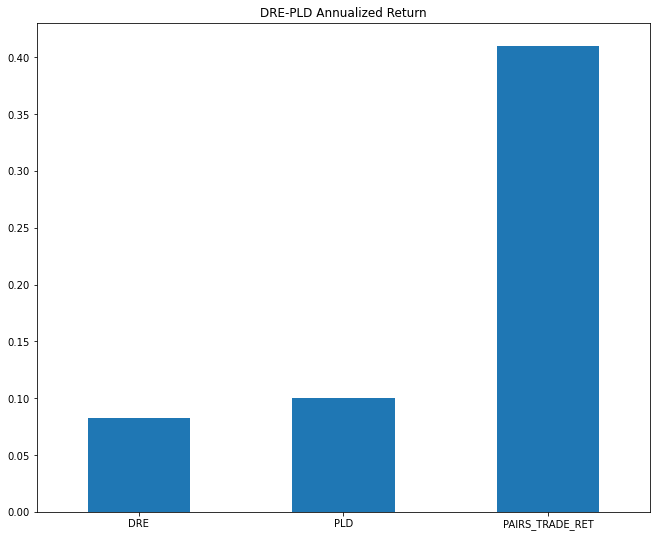

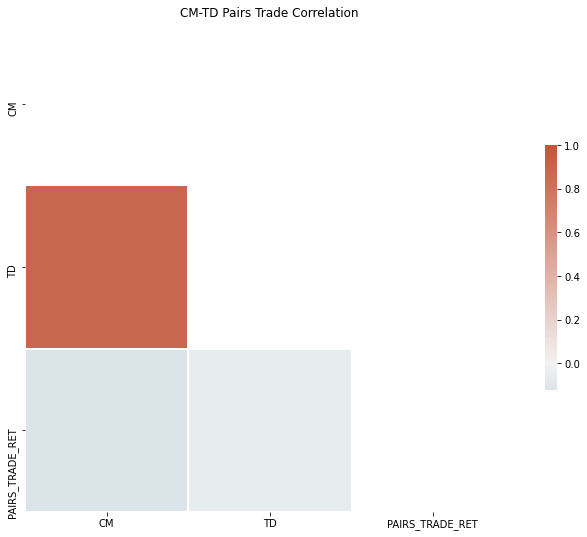

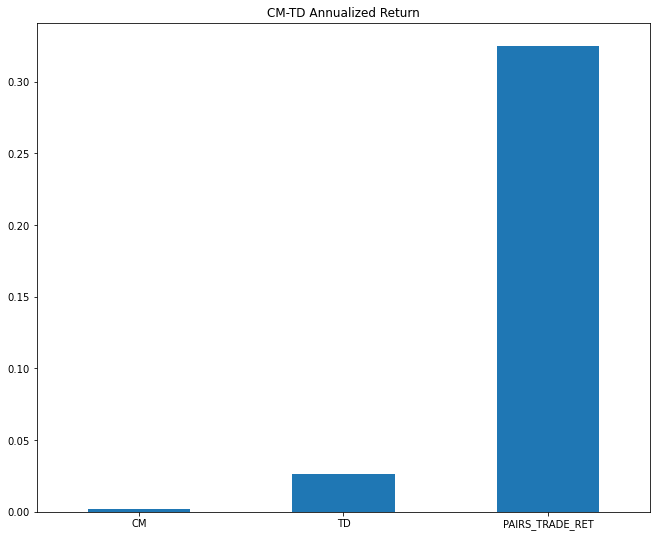

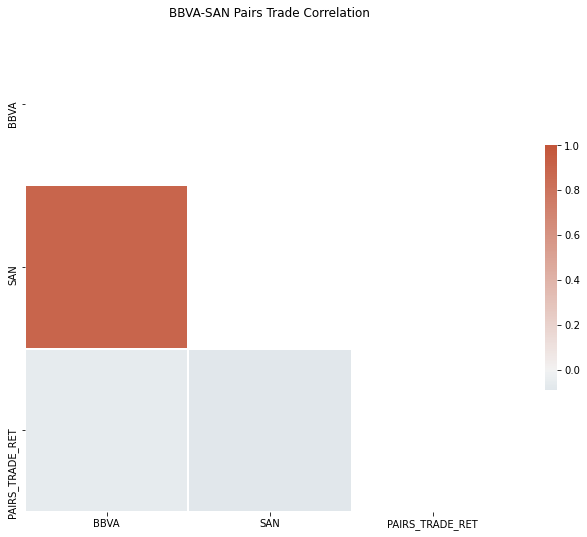

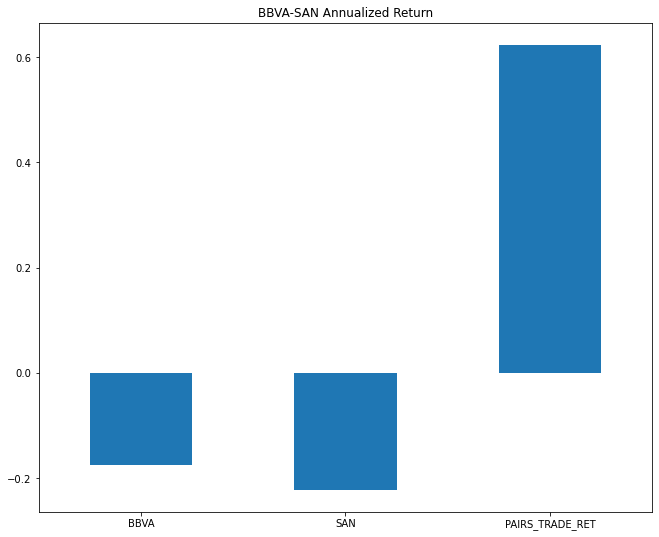

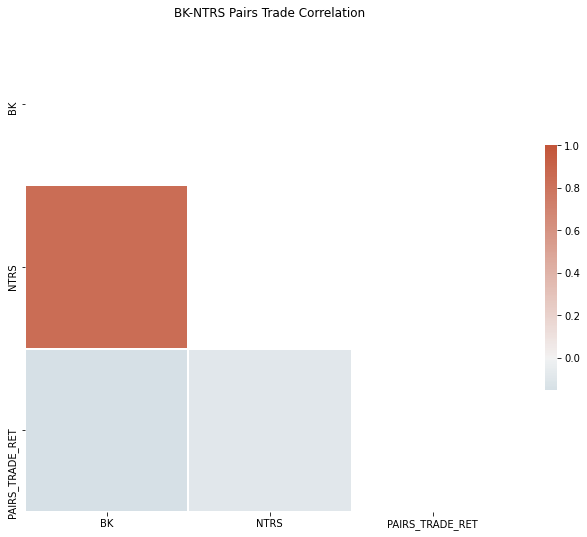

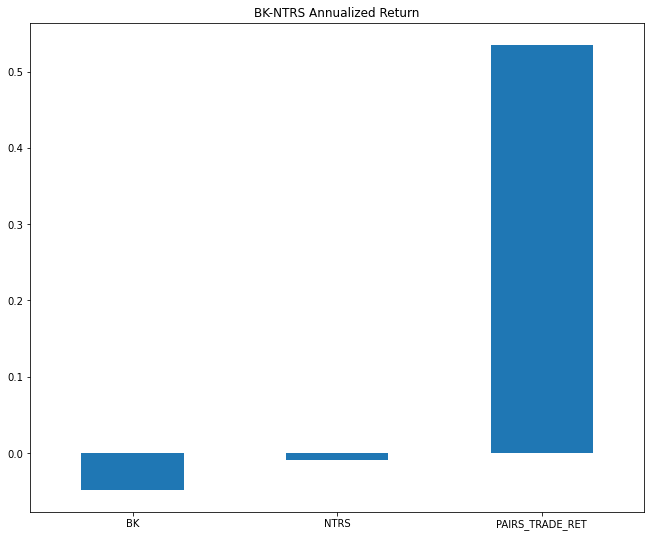

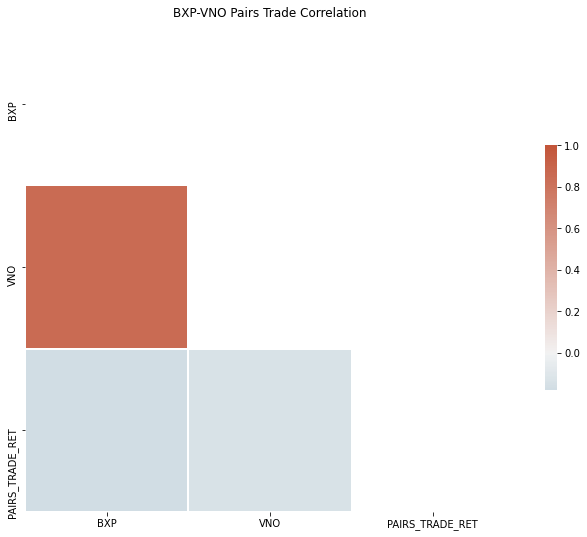

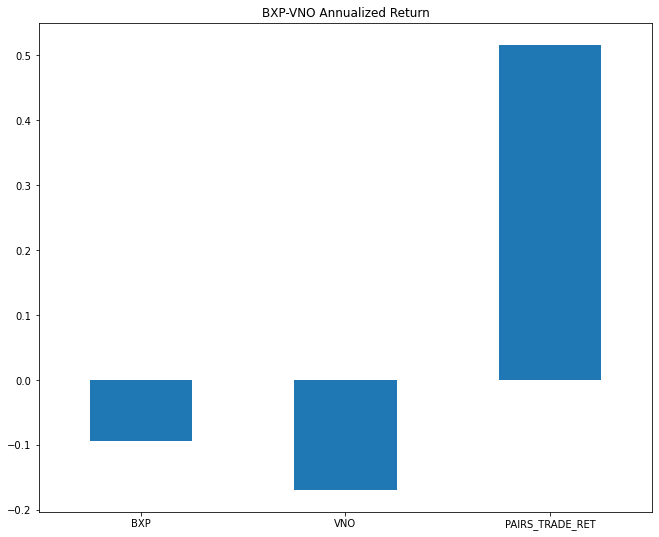

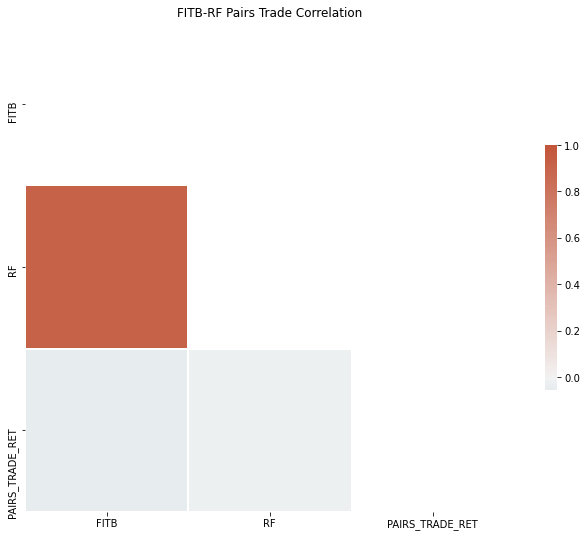

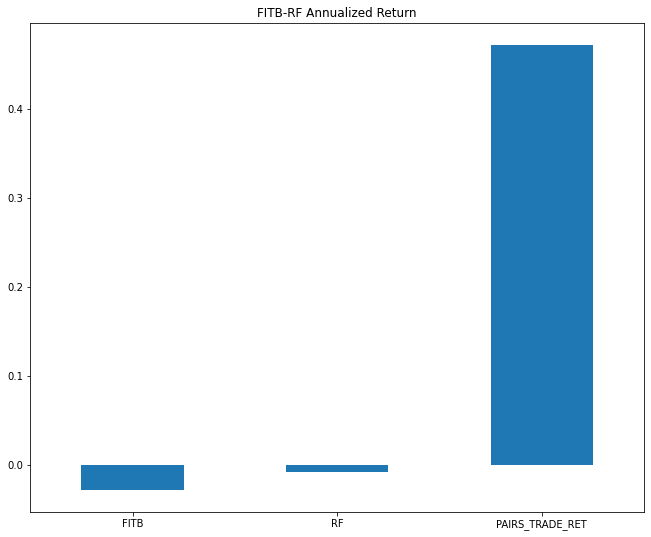

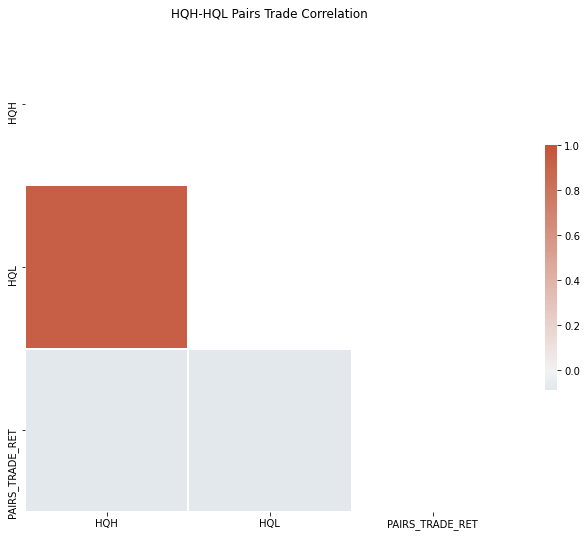

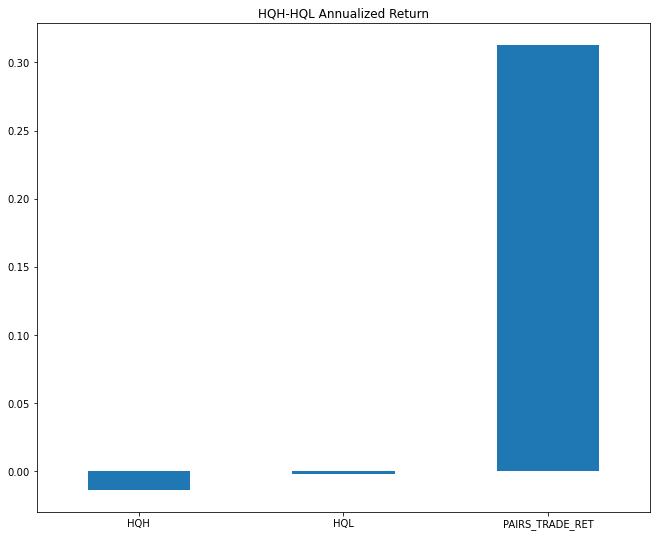

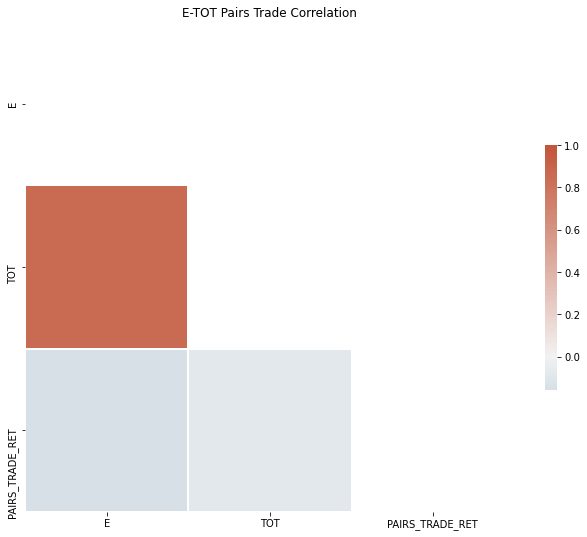

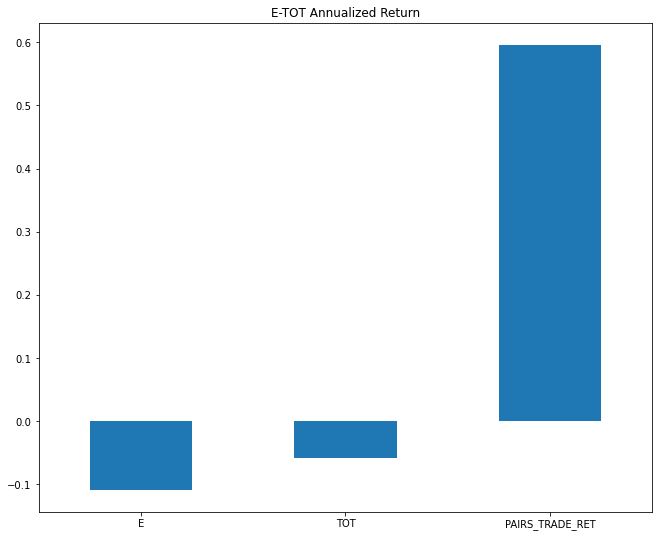

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.finance_metrics import annualized_return

def signal_to_multiplier(signal, long):
    if           signal == -1.0: return -0.50 * long
    elif -1.0 <  signal <= -0.5: return -0.25 * long
    elif -0.5 <  signal <= -0.0: return -0.10 * long
    elif  0.0 <= signal <   0.5: return  0.10 * long
    elif  0.5 <= signal <   1.0: return  0.25 * long
    elif         signal ==  1.0: return  0.50 * long
    else: raise ValueError("Out of range signal provided")

returns = {}
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)
    
    returns[pair] = pd.read_pickle(f"data/raw/{pair[0]}.zip").loc["2015-01-01":, ["Simple Return"]]
    returns[pair][pair[1]] = pd.read_pickle(f"data/raw/{pair[1]}.zip").loc["2015-01-01":, ["Simple Return"]]
    returns[pair].columns = pair
    
    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = feature_transformers[pair]
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # scale features and target column
    X_scaler = feature_scalers[pair]
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    print(f"==================================================\n"
          f"Results for pair {pair}:")
    pred_ensemble = None
    for model_type, model in models[pair].items():
        pred = [-1 if i < 0 else 1 for i in np.array(model.predict(X_test)).ravel()]
        if any(model_type == t for t in ["Random Forest", "Adaptive Boost", "Gradient Boost", "Neural Net"]):
            if pred_ensemble is None: pred_ensemble = np.array(pred) / 4
            else: pred_ensemble = pred_ensemble + (np.array(pred) / 4)
            returns[pair][model_type] = pred
    returns[pair]["Ensemble"] = np.mean(
        returns[pair].loc[:, ["Random Forest", "Adaptive Boost", "Gradient Boost", "Neural Net"]], axis=1)
    returns[pair]["Ensemble"] = pred_ensemble
    returns[pair][pair[0] + "_SIGNAL"] = [signal_to_multiplier(sig,  1) for sig in pred_ensemble]
    returns[pair][pair[1] + "_SIGNAL"] = [signal_to_multiplier(sig, -1) for sig in pred_ensemble]
    returns[pair][pair[0] + "_ADJRET"] = returns[pair][pair[0]] * returns[pair][pair[0] + "_SIGNAL"]
    returns[pair][pair[1] + "_ADJRET"] = returns[pair][pair[1]] * returns[pair][pair[1] + "_SIGNAL"]
    returns[pair]["PAIRS_TRADE_RET"] = np.mean(returns[pair][[p+"_ADJRET" for p in pair]], axis=1)
    ann_ret = annualized_return(returns[pair].loc[:, [pair[0],pair[1],"PAIRS_TRADE_RET"]])

    conf_mat = confusion_matrix(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    accuracy = accuracy_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    precision = precision_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    recall = recall_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    f1 = f1_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])

    print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net\n"
          f"  - Confusion Matrix:\n{conf_mat}\n"
          f"  - Accuracy: {accuracy:.06f}\n"
          f"  - Recall: {recall:.06f}\n"
          f"  - Precision: {precision:.06f}\n"
          f"  - F1-Score: {f1:.06f}\n"
          f"- Annualized Return:\n"
          f"  - {pair[0]}: {ann_ret[pair[0]]:0.06f}\n"
          f"  - {pair[1]}: {ann_ret[pair[1]]:0.06f}\n"
          f"  - Pairs Trade: {ann_ret['PAIRS_TRADE_RET']:0.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")
    
    # Compute the correlation matrix
    corr = returns[pair].loc[:, [pair[0],pair[1],"PAIRS_TRADE_RET"]].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, 
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    heatmap.set_title(f"{pair[0]}-{pair[1]} Pairs Trade Correlation")
    fig = heatmap.get_figure()
    fig.savefig(f"out/img/{pair[0]}-{pair[1]}-corr.jpeg") 

    f, ax = plt.subplots(figsize=(11, 9))
    barplot = ann_ret.plot.bar()
    barplot.set_xticklabels(ann_ret.index, rotation=0)
    barplot.set_title(f"{pair[0]}-{pair[1]} Annualized Return")
    fig = barplot.get_figure()
    fig.savefig(f"out/img/{pair[0]}-{pair[1]}-return.jpeg") 
